# This is Lab 4 executable file

This file contains program code, which is the solution to the problems in the file [lab_4_task.txt](https://github.com/RazinAleksandr/M-M-MSA-ITMO/blob/main/Lab_4/lab_4_task.txt)

In [348]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import sqrt

# FEDOT framework
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.data.multi_modal import MultiModalData

from statsmodels.tsa.stattools import adfuller, acovf, ccovf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pmdarima as pm

from scipy import signal

from pykalman import KalmanFilter

import warnings
warnings.filterwarnings("ignore")

## Exercise №1

Choose about 3-6 variables from your dataset (2-3 – target variables, the rest - predictors).

In [52]:
# Data init
path = '/home/aleksrazin/ITMO/M&MSA/train_data/covid_19_ts.csv'
df = pd.read_csv(path, index_col=0)

# Preprocessing
df.daterep = pd.to_datetime(df.daterep, format='%Y-%m-%d %H:%M:%S')
df.sort_values(by='daterep', inplace=True)
df.reset_index(drop=True, inplace=True)

# Group by date
df_grouped = df.groupby('daterep', as_index=False).\
                        agg({'cases':'sum', 
                             'deaths': 'mean',
                             'cumulative_number_for_14_days_of_covid_19_cases_per_100000': 'mean',
                             'popdata2019': 'mean'})
df_grouped.rename(columns={'cumulative_number_for_14_days_of_covid_19_cases_per_100000': 'cumulative_number'}, 
                  inplace=True)

# Choose variables
# target:
target = ['cases', 'deaths']
# predictors:
predictors = ['cumulative_number', 'popdata2019']

df_grouped.head(15)

,daterep,cases,deaths,cumulative_number,popdata2019
0,2019-12-31,27,0.000000,NaN,8.788834e+07
1,2020-01-01,0,0.000000,NaN,8.788834e+07
2,2020-01-02,0,0.000000,NaN,8.788834e+07
3,2020-01-03,17,0.000000,NaN,8.788834e+07
4,2020-01-04,0,0.000000,NaN,8.788834e+07
5,2020-01-05,15,0.000000,NaN,8.788834e+07
6,2020-01-06,0,0.000000,NaN,8.788834e+07
7,2020-01-07,0,0.000000,NaN,8.788834e+07
8,2020-01-08,0,0.000000,NaN,8.788834e+07
9,2020-01-09,0,0.000000,NaN,8.788834e+07


In [53]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   daterep            212 non-null    datetime64[ns]
 1   cases              212 non-null    int64         
 2   deaths             212 non-null    float64       
 3   cumulative_number  199 non-null    float64       
 4   popdata2019        212 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 8.4 KB


In [54]:
# Fill NaN values with spline to obtain a smooth surface passing through the input points
df_grouped['cumulative_number'].\
    interpolate(method='spline', order=1, limit_direction='backward', limit=30, inplace=True)

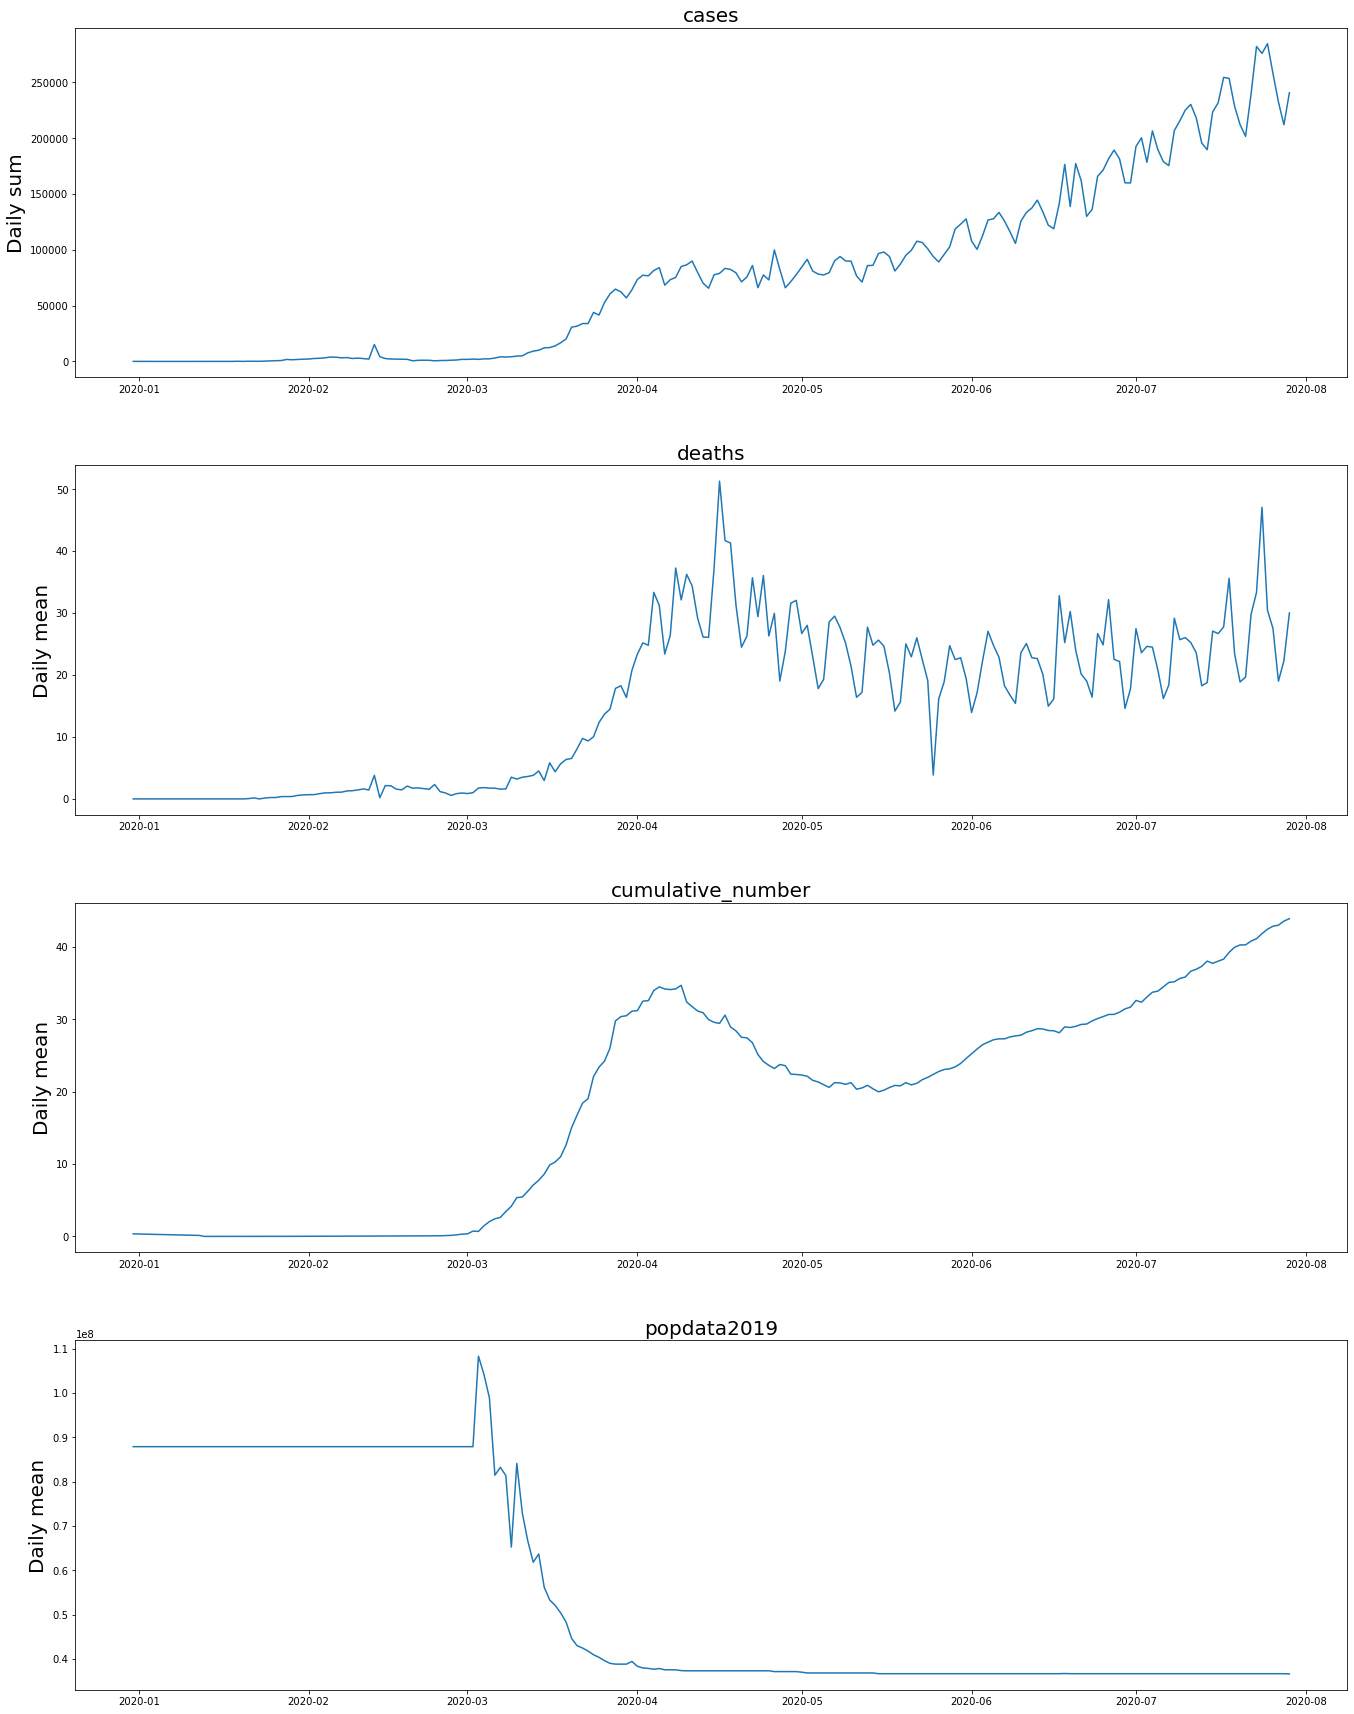

In [55]:
# Data plotting
fig, axes = plt.subplots(df_grouped.shape[1]-1, figsize=(20, 5 * df_grouped.shape[1]))

for idx, col_name in enumerate(df_grouped.columns.to_list()[1:]):
    axes[idx].plot(df_grouped.daterep, df_grouped[col_name])
    axes[idx].set_title(col_name, fontsize = 20)
    axes[idx].set_ylabel('Daily sum' if col_name == 'cases' else 'Daily mean', fontsize = 20)
plt.tight_layout(pad=5)

## Exercise №2

Analyze stationarity of a process (for mathematical expectation and variance) for all chosen variables. Make them more stationary if needed.

In [56]:
# Check stationarity
non_stat = []

for i in df_grouped.columns.to_list()[1:]:
    adf = adfuller(df_grouped[i])[1]
    if adf > 0.05:
        non_stat.append(i)
        print(f'Non stationary time-series: {i}, adfuller test: {adf}')

Non stationary time-series: cases, adfuller test: 0.9932830148780438
Non stationary time-series: deaths, adfuller test: 0.49663567809826425
Non stationary time-series: cumulative_number, adfuller test: 0.6530942750171755
Non stationary time-series: popdata2019, adfuller test: 0.5787588652247337


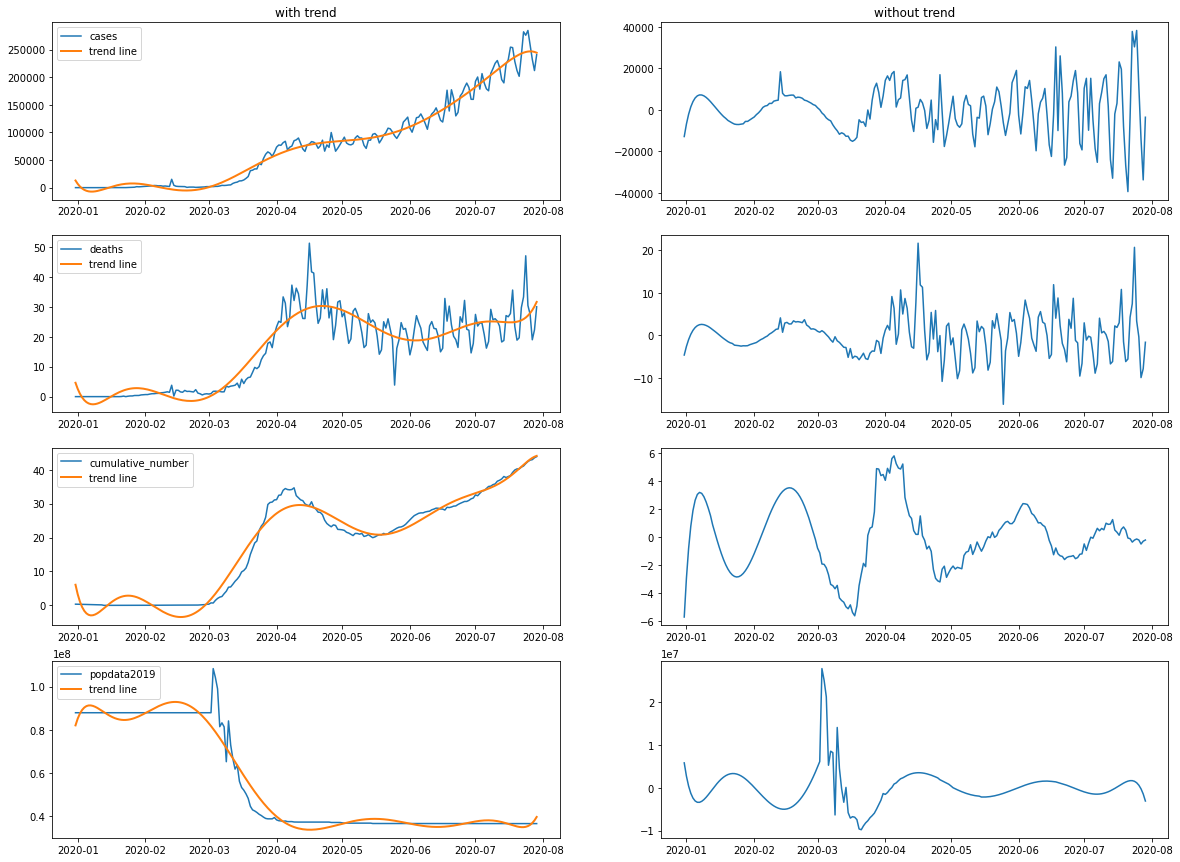

In [57]:
# Make time series more stationary

# Find the trend
def trendline(data, order=9):
    #polynomial trend
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)

fig, axes = plt.subplots(df_grouped.shape[1]-1, 2, figsize=(20, 3 * df_grouped.shape[1]))
for i, col in enumerate(df_grouped.columns.to_list()[1:]):
    trend = trendline(df_grouped[col]) # build trend

    axes[i, 0].plot(df_grouped['daterep'], df_grouped[col], label=col)
    axes[i, 0].plot(df_grouped['daterep'], trend, linewidth=2, label='trend line')
    axes[i, 0].legend(loc="upper left")
    
    axes[i, 1].plot(df_grouped['daterep'], df_grouped[col]-trend) # remove trend

    if i == 0:
        axes[i, 0].set_title('with trend')
        axes[i, 1].set_title('without trend')

plt.show()

In [58]:
# Remove all trends
for i in non_stat:
    trend = trendline(df_grouped[i])
    df_grouped[i] = df_grouped[i]-trend

In [59]:
# Check stationarity after trend removing
non_stat = []
for i in df_grouped.columns.to_list()[1:]:
    adf = adfuller(df_grouped[i])[1]
    print(f'Time-series: {i}, adfuller test: {adf}')

Time-series: cases, adfuller test: 0.0008330227512344757
Time-series: deaths, adfuller test: 0.000979660352588229
Time-series: cumulative_number, adfuller test: 3.4556230018395404e-06
Time-series: popdata2019, adfuller test: 7.474529331922488e-05


## Exercise №3

Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets.

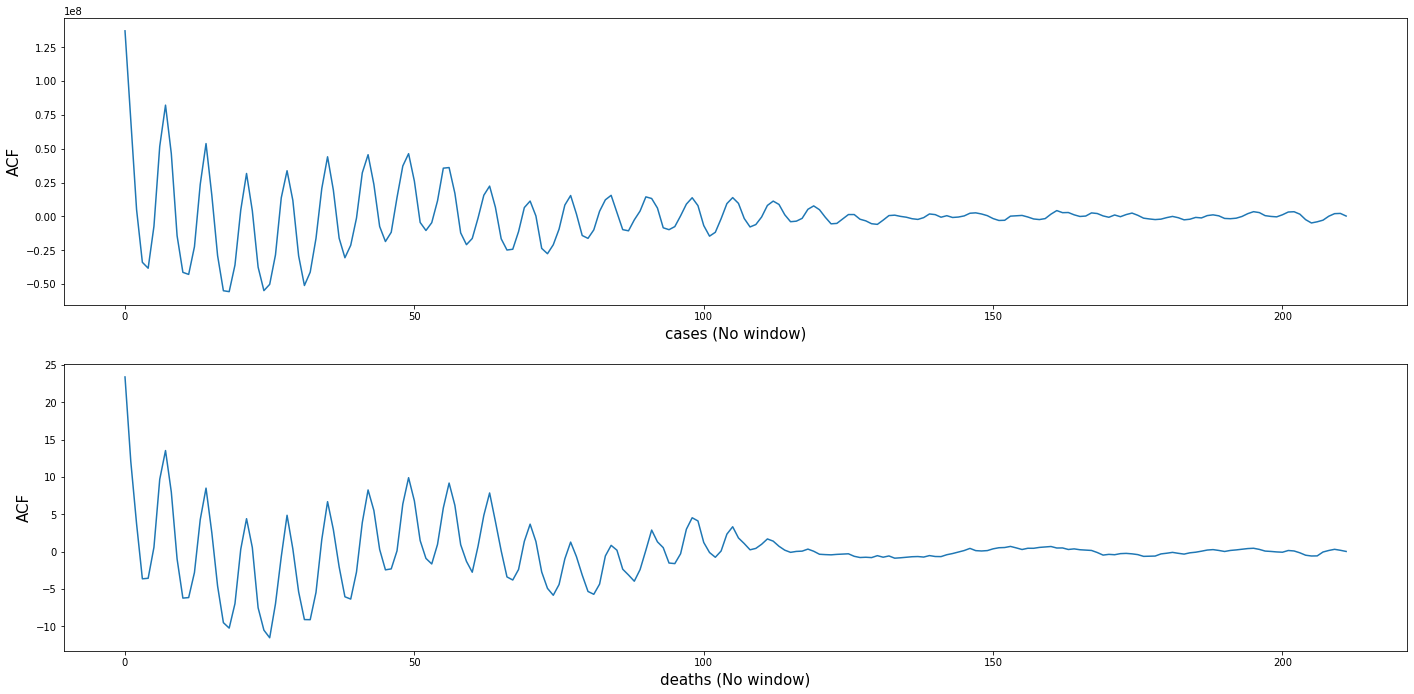

In [60]:
# Analyze covariance function

# Autocovariance without window
fig, axes = plt.subplots(len(target), figsize=(20, 5 * len(target)))

for idx, col_name in enumerate(target):
    axes[idx].plot(acovf(df_grouped[col_name],fft=False)) 
    axes[idx].set_xlabel(col_name + " (No window)", fontsize = 15)
    axes[idx].set_ylabel('ACF', fontsize = 15)
plt.tight_layout(pad=2)

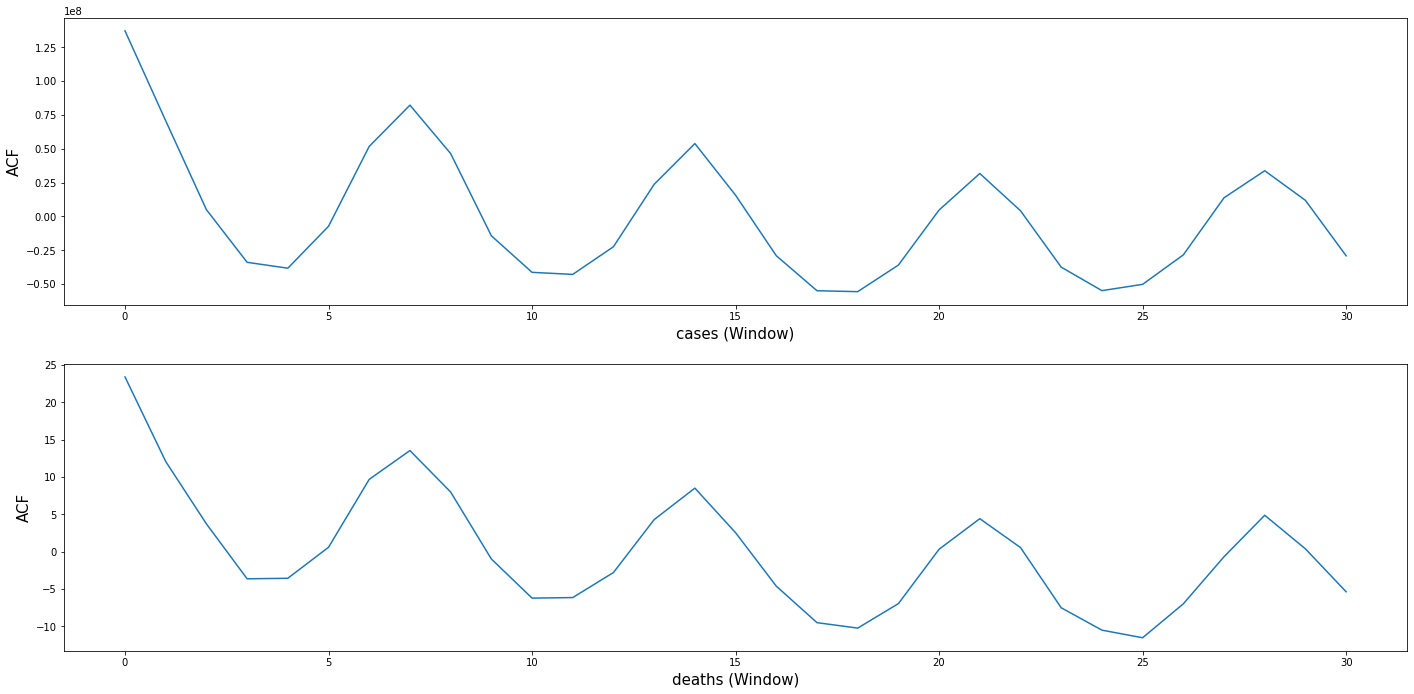

In [61]:
# Autocovariance with window
fig, axes = plt.subplots(len(target), figsize=(20, 5 * len(target)))

window_size = 30
for idx, col_name in enumerate(target):
    axes[idx].plot(acovf(df_grouped[col_name],nlag=window_size, fft=False)) 
    axes[idx].set_xlabel(col_name + " (Window)", fontsize = 15)
    axes[idx].set_ylabel('ACF', fontsize = 15)
plt.tight_layout(pad=2)

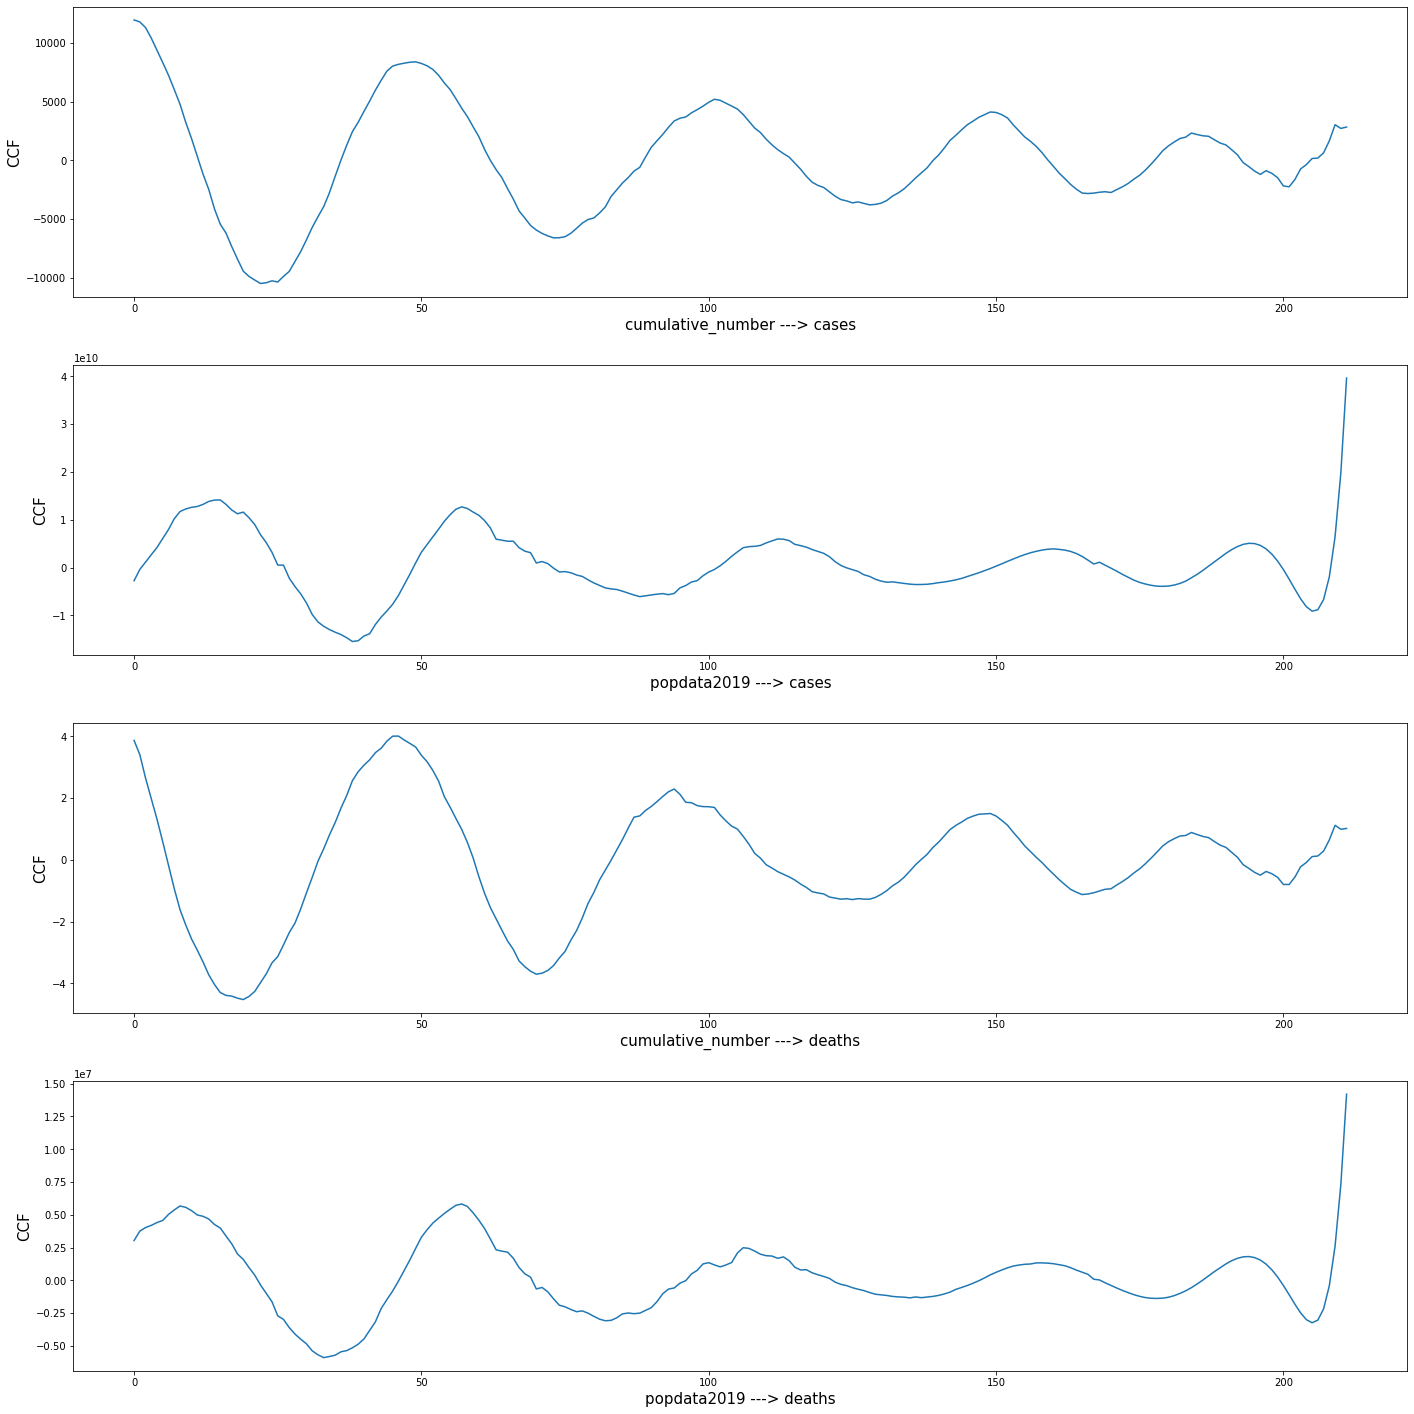

In [62]:
# Analize the cross-covariance between predictor ---> target
fig, axes = plt.subplots(len(target)+len(predictors), figsize=(20, 5 * (len(target)+len(predictors))))

idx = 0
for target_col in target:
    for pred_col in predictors:
        axes[idx].plot(ccovf(x=df_grouped[pred_col],y=df_grouped[target_col], fft=False)) 
        axes[idx].set_xlabel(f'{pred_col} ---> {target_col}', fontsize = 15)
        axes[idx].set_ylabel('CCF', fontsize = 15)
        idx += 1
plt.tight_layout(pad=2)

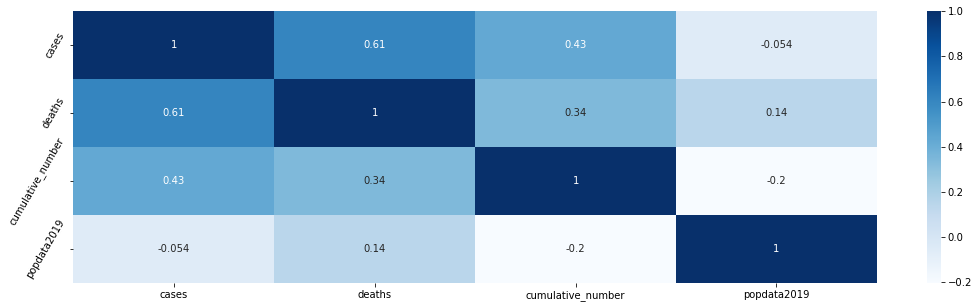

In [63]:
# Show Cross correlation matrix

# Correlation coefficients
plt.figure(figsize=(18, 5))
sns.heatmap(df_grouped.corr(), cmap='Blues', annot=True)
plt.yticks(rotation=60)
plt.show()

## Exercise №4

Filter high frequencies (noise) with chosen 2 filters for target variables

In [64]:
# Prepare data for FEDOT
input_data_list = []

# Define task - time series forecasting
# and forecast horizon 
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))

# Convert into numpy array first
for targ_name in target:
    time_series = np.array(df_grouped[targ_name])
    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)

    input_data_list.append(input_data)

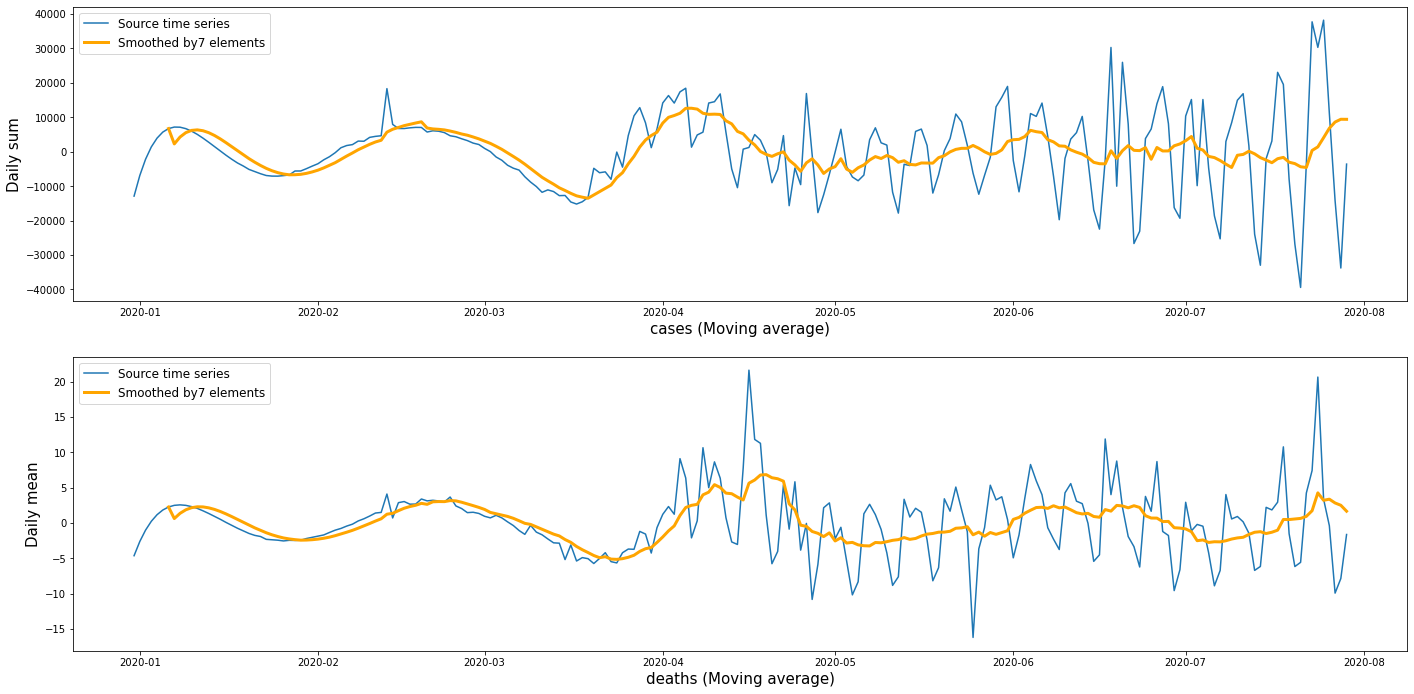

In [65]:
# Moving average filter 
window_size = 7

smoothing_node = PrimaryNode('smoothing') 
smoothing_node.custom_params = {'window_size': window_size}

def node_fit_predict(node, input_data):
    """ Fit node and make prediction """
    node.fit(input_data)
    smoothed_output = node.predict(input_data)
    return smoothed_output

roll_filt_targs = []

fig, axes = plt.subplots(len(target), figsize=(20, 5 * len(target)))

for idx, col_name in enumerate(target):
    smoothed_output = node_fit_predict(smoothing_node, input_data_list[idx])
    roll_filt_targs.append(smoothed_output.predict[window_size-1:]) # Cut First elements, that coinside with pure data (input)

    axes[idx].plot(df_grouped.daterep, input_data_list[idx].target, label='Source time series')
    axes[idx].plot(df_grouped.daterep[window_size-1:], 
                   smoothed_output.predict[window_size-1:], 
                   label='Smoothed by'+str(window_size)+' elements', 
                   c="orange", 
                   linewidth=3)
    
    axes[idx].set_xlabel(col_name+" (Moving average)", fontsize = 15)
    axes[idx].set_ylabel('Daily sum' if col_name == 'cases' else 'Daily mean', fontsize = 15)
    axes[idx].legend(loc="upper left", fontsize=12)
plt.tight_layout(pad=2)

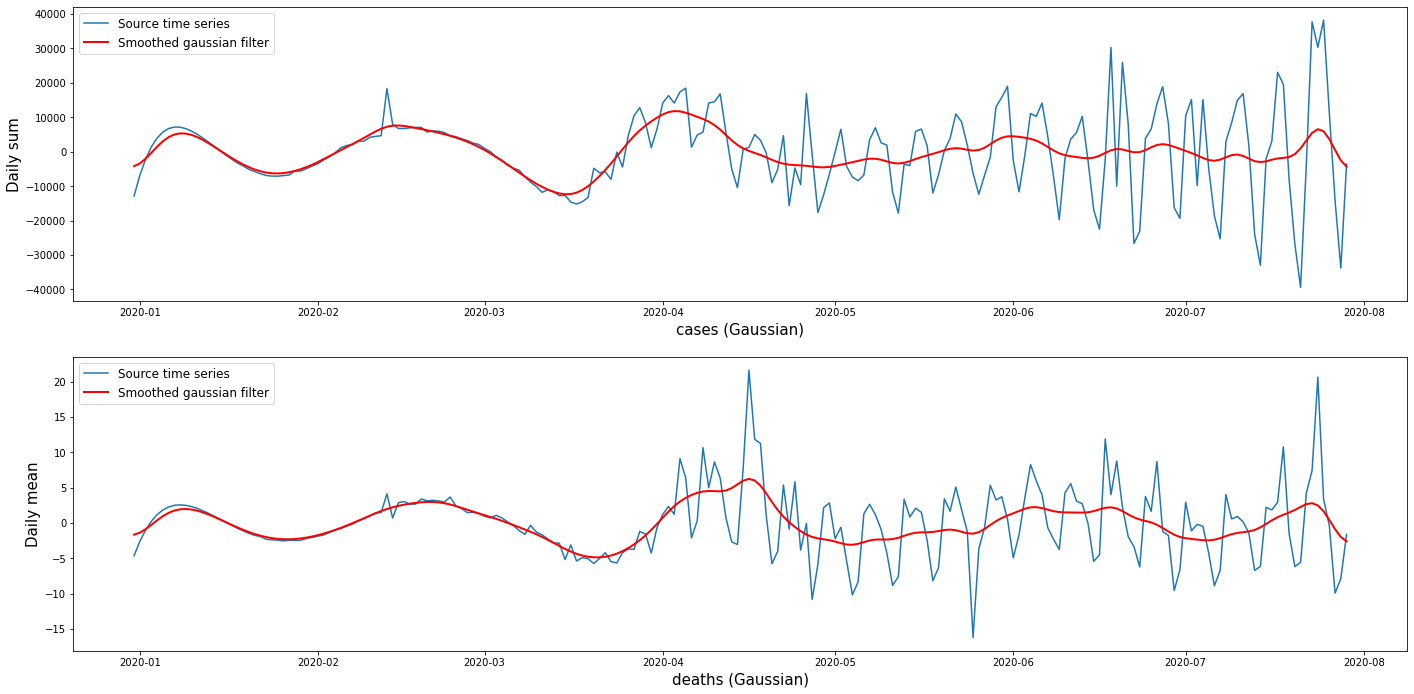

In [66]:
# Gaussian filter
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 3}

# Prepare data for spectral analisys
gaus_filt_targs = []
pure_targs = []

fig, axes = plt.subplots(len(target), figsize=(20, 5 * len(target)))

for idx, col_name in enumerate(target):
    smoothed_gaussian = node_fit_predict(gaussian_node, input_data_list[idx])
    gaus_filt_targs.append(smoothed_gaussian.predict)
    pure_targs.append(input_data_list[idx].target)
    
    axes[idx].plot(df_grouped.daterep, input_data_list[idx].target, label='Source time series')
    axes[idx].plot(df_grouped.daterep, 
                   smoothed_gaussian.predict, 
                   label='Smoothed gaussian filter', 
                   linewidth=2, 
                   c='red')
    
    axes[idx].set_xlabel(col_name+" (Gaussian)", fontsize = 15)
    axes[idx].set_ylabel('Daily sum' if col_name == 'cases' else 'Daily mean', fontsize = 15)
    axes[idx].legend(loc="upper left", fontsize=12)
plt.tight_layout(pad=2)

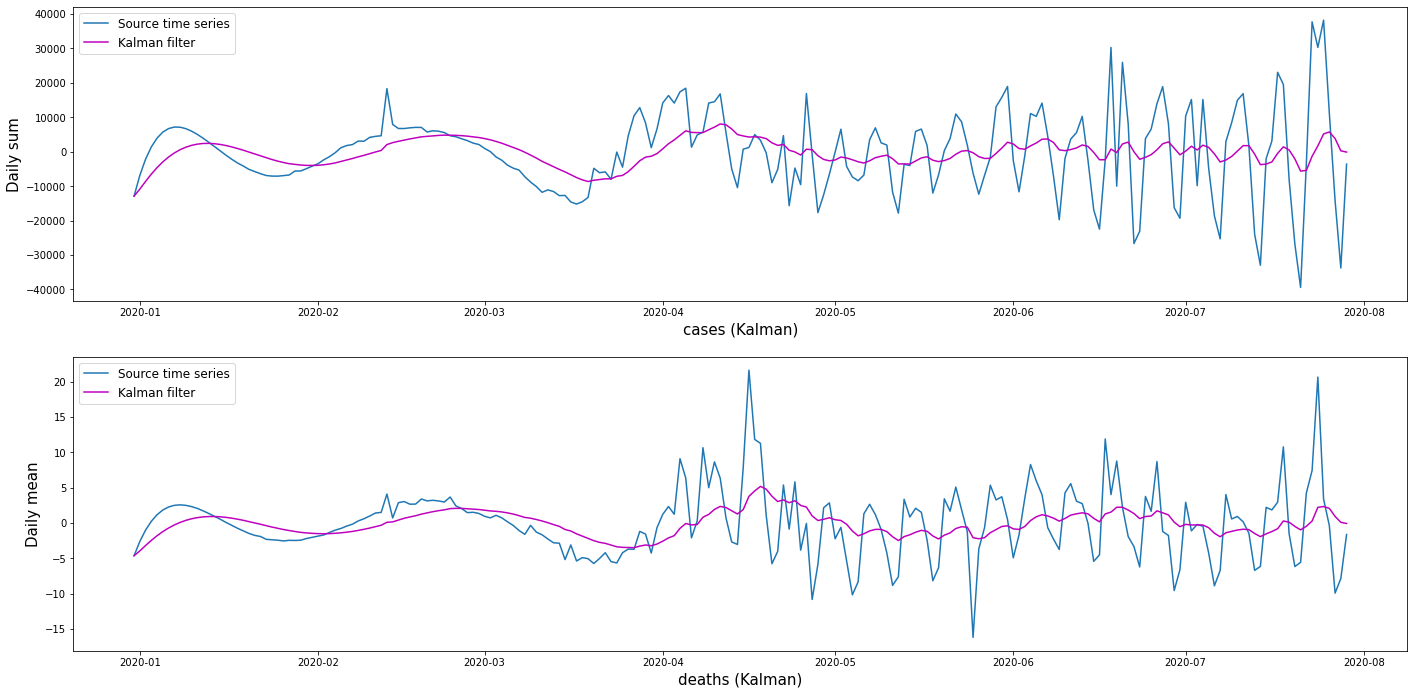

In [67]:
# Kalman filter
def kalman_filter(data):
    
    kf = KalmanFilter(transition_matrices=[1],  # A transition matrix of states between times t и t+1 
          observation_matrices=[1],  # C surveillance matrix
          initial_state_mean=data[0],  # average initial state
          initial_state_covariance=[1],  # covariance of the initial state distribution
          observation_covariance=[1],  # R covariance observation matrix 
          transition_covariance= 0.01)  # Q covariance transition matrix of states 
    
    state_means_0, _ = kf.filter(data)
    state_means_0 = [w[0] for w in state_means_0]
    return state_means_0

fig, axes = plt.subplots(len(target), figsize=(20, 5 * len(target)))

Kalman_filt_targs = []
for idx, col_name in enumerate(target):
    kalm = kalman_filter(np.array(df_grouped[col_name]))
    Kalman_filt_targs.append(kalm)
    
    axes[idx].plot(df_grouped.daterep, df_grouped[col_name], label='Source time series')
    axes[idx].plot(df_grouped.daterep, kalm, label='Kalman filter', c='m')
    
    axes[idx].set_xlabel(col_name+" (Kalman)", fontsize = 15)
    axes[idx].set_ylabel('Daily sum' if col_name == 'cases' else 'Daily mean', fontsize = 15)
    axes[idx].legend(loc="upper left", fontsize=12)
plt.tight_layout(pad=2)

## Exercise 5

Estimate spectral density function for with and without filtering

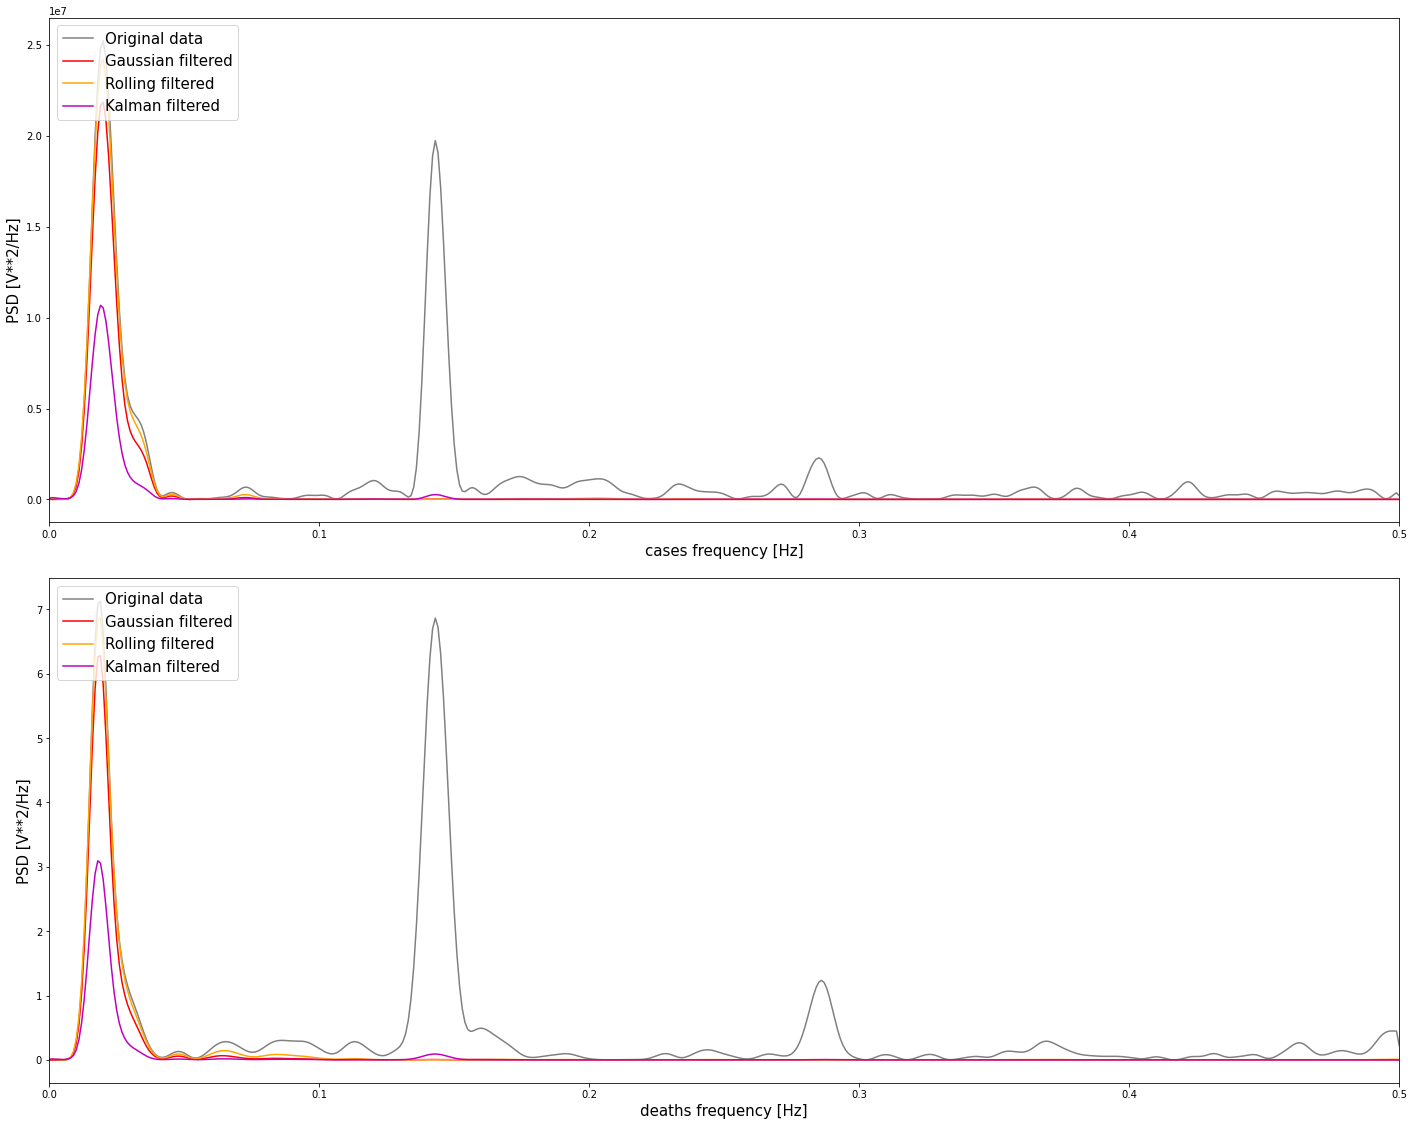

In [68]:
# Plot spectrum for source and filtered data
window_size = 72
blackman = signal.blackman(M=window_size)
bartlett = signal.hanning(M=window_size)

fig, axes = plt.subplots(len(target), figsize=(20, 8 * len(target)))

for col_idx, col_name in enumerate(target):
    f, Pxx_den = signal.welch(pure_targs[col_idx], fs=1, scaling='spectrum', nfft = 1000) # Spectrum for orig data
    f_flt_g, Pxx_flt_g = signal.welch(gaus_filt_targs[col_idx], fs=1, nfft = 1000, scaling='spectrum')
    f_flt_r, Pxx_flt_r = signal.welch(roll_filt_targs[col_idx], fs=1, nfft = 1000, scaling='spectrum')
    f_flt_k, Pxx_flt_k = signal.welch(Kalman_filt_targs[col_idx], fs=1, nfft = 1000, scaling='spectrum')

    axes[col_idx].plot(f, Pxx_den, color="grey", label='Original data')
    axes[col_idx].plot(f_flt_g, Pxx_flt_g, color="red", label='Gaussian filtered')
    axes[col_idx].plot(f_flt_r, Pxx_flt_r, color="orange", label='Rolling filtered')
    axes[col_idx].plot(f_flt_k, Pxx_flt_k, color="m", label='Kalman filtered')

    axes[col_idx].set_xlabel(col_name+' frequency [Hz]', fontsize = 15)
    axes[col_idx].set_ylabel(u'PSD [V**2/Hz]', fontsize = 15)
    axes[col_idx].set_xlim((0,0.5))
    axes[col_idx].legend(loc="upper left", fontsize = 15)
plt.tight_layout(pad=2)

## Exercise №6

Built auto-regression model filtered and non-filtered data. To analyze residual error and to define appropriate order of model

In [69]:
# Prepare data for FEDOT
orig_input_data_list = []
orig_train = []
orig_test = []
filter_input_data_list = []
filter_train = []
filter_test = []

# Define task - time series forecasting
# and forecast horizon 
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=40))

# Prepare original data
for col_idx in range(len(target)):
    time_series = pure_targs[col_idx] 
    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)
    train, test = train_test_data_setup(input_data)

    orig_input_data_list.append(input_data)
    orig_train.append(train)
    orig_test.append(test)

# Prepare filtered data
for col_idx in range(len(target)):
    time_series = gaus_filt_targs[col_idx]
    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)
    train, test = train_test_data_setup(input_data)

    filter_input_data_list.append(input_data)
    filter_train.append(train)
    filter_test.append(test)

Start pipeline tuning
Hyperparameters optimization start
100%|████████| 500/500 [00:18<00:00, 27.68trial/s, best loss: 5323.384960260493]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 5323.385 equal or smaller than initial (+ 5% deviation) 10577.031
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False
Pipeline structure:
{'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 35.66217171269786, 'lag_2': 56.34429531681461}
Start pipeline tuning
Hyperparameters optimization start
100%|████████| 500/500 [00:19<00:00, 25.01trial/s, best loss: 3.068569770820156]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 3.069 equal or smaller than initial (+ 5% deviation) 3.423
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to 

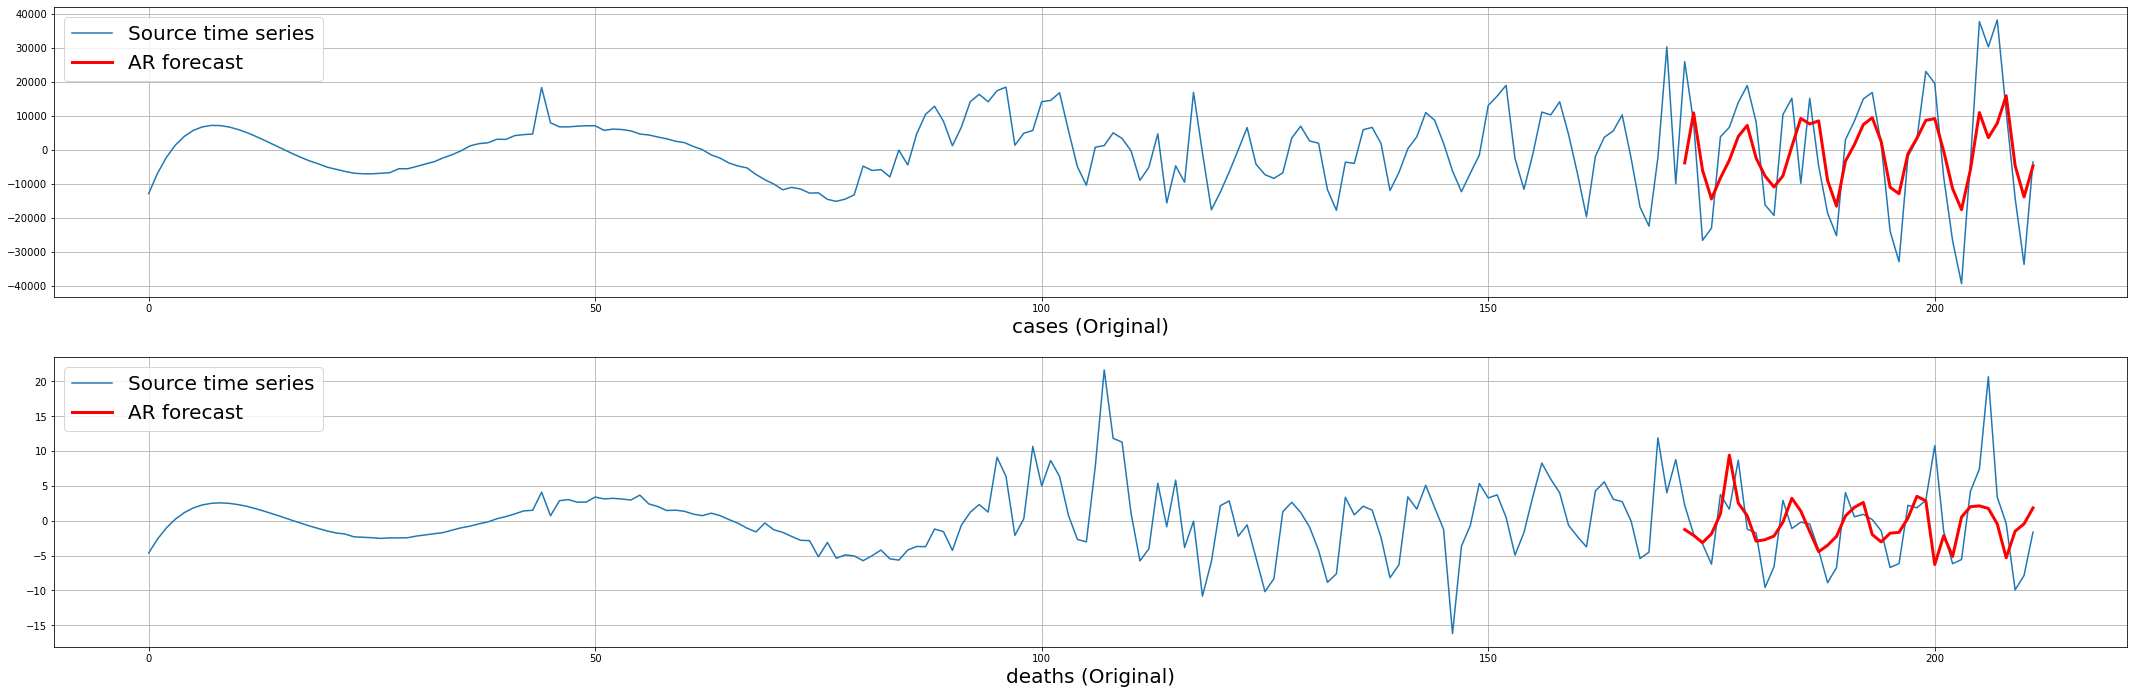

In [70]:
# AR model for original (non-filtered) data
fig, axes = plt.subplots(len(target), figsize=(30, 5 * len(target)))

for col_idx, col_name in enumerate(target):
    pipeline = Pipeline(PrimaryNode('ar'))
    pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                            loss_params=None, input_data=orig_train[col_idx],
                                            iterations=500, timeout=5)
                                            #cv_folds=1, validation_blocks=2)

    fitted_vals = pipeline.fit(orig_train[col_idx])
    forecast = pipeline.predict(orig_test[col_idx])

    axes[col_idx].plot(orig_input_data_list[col_idx].idx, 
                       orig_input_data_list[col_idx].target, 
                       label='Source time series')
    axes[col_idx].plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast', c='red', linewidth=3)
    axes[col_idx].grid()
    axes[col_idx].legend(fontsize = 20)
    axes[col_idx].set_xlabel(col_name+' (Original)', fontsize = 20)

    pipeline.print_structure()
plt.tight_layout(pad=2)

Start pipeline tuning
Hyperparameters optimization start
100%|███████| 500/500 [00:17<00:00, 28.23trial/s, best loss: 1165.0876962045106]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 1165.088 equal or smaller than initial (+ 5% deviation) 8612.103
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False
Pipeline structure:
{'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 49.5634963662884, 'lag_2': 3.0126517818308045}
Start pipeline tuning
Hyperparameters optimization start
100%|███████| 500/500 [00:18<00:00, 27.33trial/s, best loss: 0.7894737674048578]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 0.789 equal or smaller than initial (+ 5% deviation) 2.224
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to F

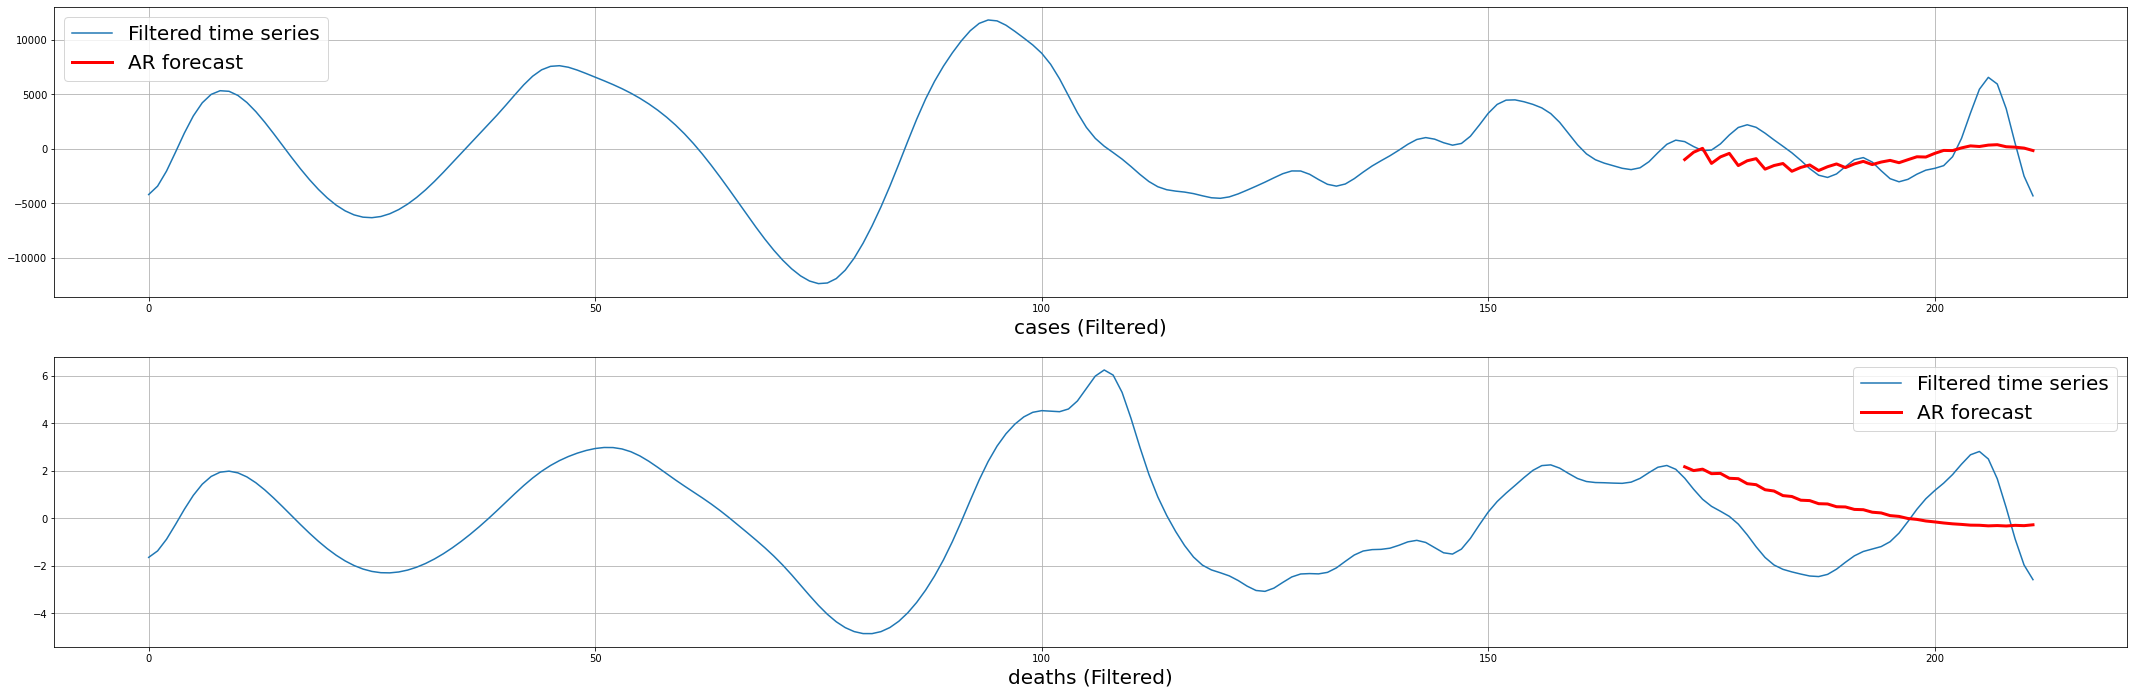

In [71]:
# AR model for filtered data
fig, axes = plt.subplots(len(target), figsize=(30, 5 * len(target)))

for col_idx, col_name in enumerate(target):
    pipeline = Pipeline(PrimaryNode('ar'))
    pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                            loss_params=None, input_data=filter_train[col_idx],
                                            iterations=500, timeout=5)
                                            #cv_folds=3, validation_blocks=2)

    fitted_vals = pipeline.fit(filter_train[col_idx])
    forecast = pipeline.predict(filter_test[col_idx])

    axes[col_idx].plot(filter_input_data_list[col_idx].idx, 
                       filter_input_data_list[col_idx].target, 
                       label='Filtered time series')
    axes[col_idx].plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast', c='red', linewidth=3)
    axes[col_idx].grid()
    axes[col_idx].legend(fontsize = 20)
    axes[col_idx].set_xlabel(col_name+' (Filtered)', fontsize = 20)

    pipeline.print_structure()
plt.tight_layout(pad=2)

Using ARIMA and SARIMAX models

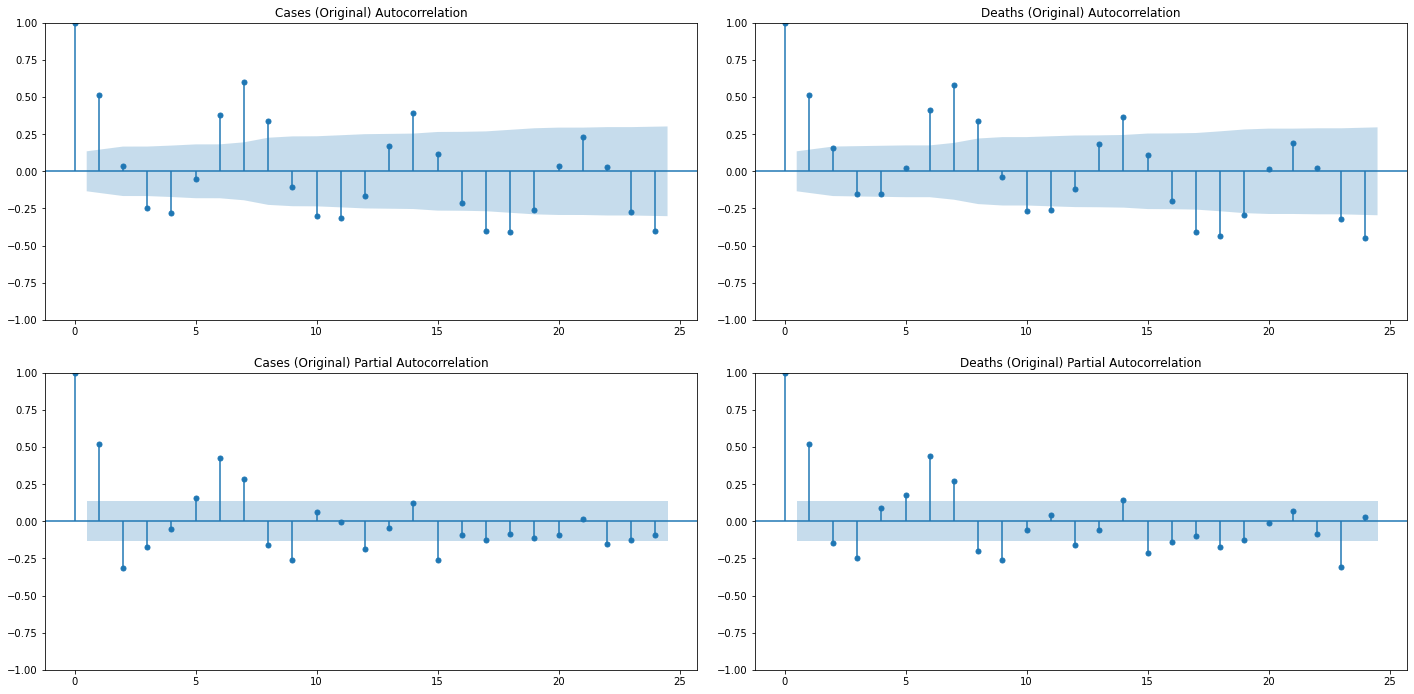

In [237]:
# Plotting ACF & PACF for original data
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

plot_acf(df_grouped.cases, ax=axes[0,0], title='Cases (Original) Autocorrelation')
plot_pacf(df_grouped.cases, ax=axes[1,0], title='Cases (Original) Partial Autocorrelation')

plot_acf(df_grouped.deaths, ax=axes[0,1], title='Deaths (Original) Autocorrelation')
plot_pacf(df_grouped.deaths, ax=axes[1,1], title='Deaths (Original) Partial Autocorrelation')

plt.tight_layout(pad=2)

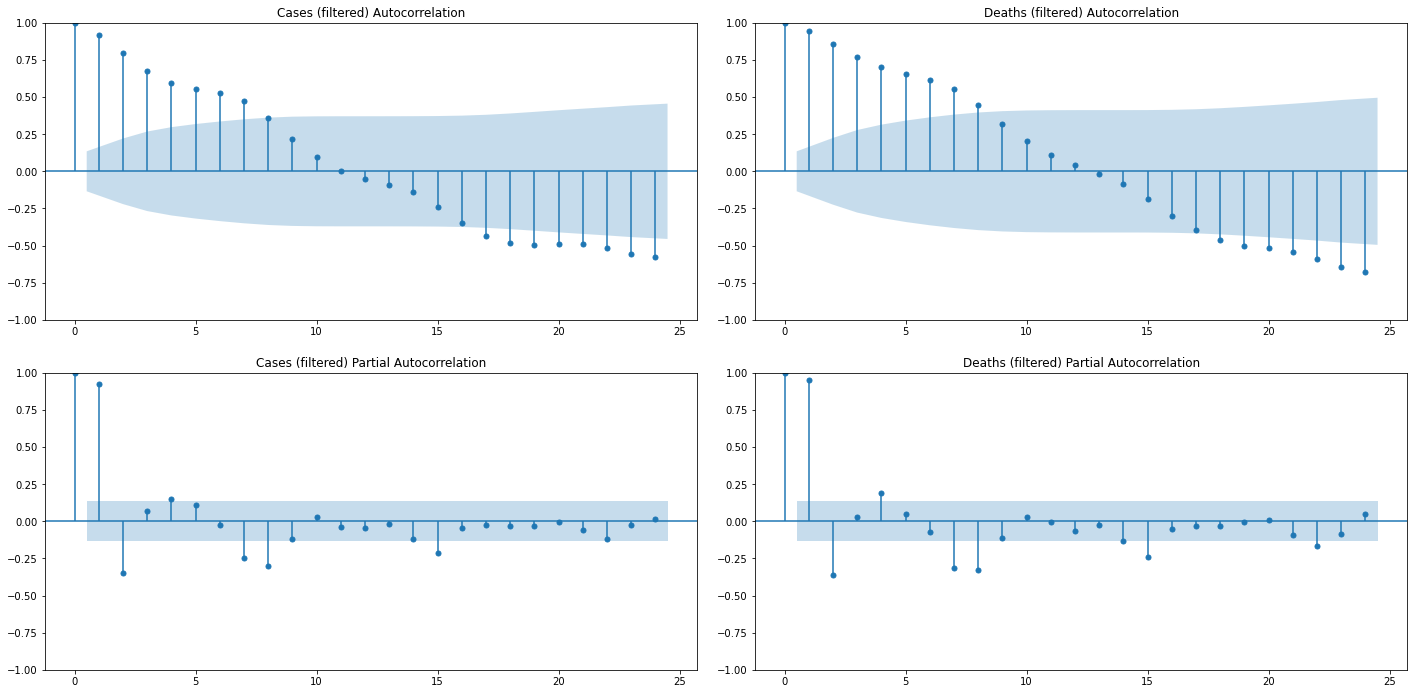

In [236]:
# Plotting ACF & PACF for filtered data
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

plot_acf(np.array(Kalman_filt_targs[0]), ax=axes[0,0], title='Cases (filtered) Autocorrelation')
plot_pacf(np.array(Kalman_filt_targs[0]), ax=axes[1,0], title='Cases (filtered) Partial Autocorrelation')

plot_acf(np.array(Kalman_filt_targs[1]), ax=axes[0,1], title='Deaths (filtered) Autocorrelation')
plot_pacf(np.array(Kalman_filt_targs[1]), ax=axes[1,1], title='Deaths (filtered) Partial Autocorrelation')

plt.tight_layout(pad=2)

In [301]:
# Build ARIMA and SARIMAX models
def arima_forecast(X_train, X_test, y_train, y_test, target_name, order, seasonal_order, model_name):
    if model_name == 'ARIMA':
        model = ARIMA(y_train, exog=X_train, order=order, seasonal_order=seasonal_order).fit()
        # Forecast
        predictions = model.forecast(20, exog=X_test, alpha=0.05)  # 95% conf
    else:
        model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order).fit(disp=False)  
        # Forecast
        predictions = model.predict(start=y_train.shape[0], end=y_train.shape[0] + y_test.shape[0] -1, exog=X_test)
    

    # Plot
    plt.figure(figsize=(20,6), dpi=100)

    plt.axvline(x=X_train.shape[0], c='r', linestyle='--', label='devide-train/test')
    plt.plot(y_train, label='Train data')
    plt.plot(np.arange(X_train.shape[0], X.shape[0]), y_test, label='Real data')
    plt.plot(np.arange(X_train.shape[0], X.shape[0]), predictions, label='Predictions', c='r')

    plt.title(f'{target_name} predictions by {model_name} model, MAPE: \
                {mean_absolute_percentage_error(y_test, predictions)*100}')
    plt.legend(loc='upper left', fontsize=10)
    plt.show()
    
    ### metrics
    rmse = sqrt(mean_squared_error(y_test, predictions))  # RMSE
    mape = mean_absolute_percentage_error(y_test, predictions)  # MAPE
    r2 = r2_score(y_test, predictions)  # r2

    return rmse, mape, r2

In [307]:
# Make our model predicting target variables by previous month data
df_with_lags = df_grouped.copy()
df_with_lags[['cases_lag_1', 'deaths_lag_1', 'cumulative_number_lag_1','popdata2019_lag_1']] = \
    df_with_lags[['cases', 'deaths', 'cumulative_number', 'popdata2019']].shift(periods=1)
df_with_lags.dropna(inplace=True)
df_with_lags.reset_index(drop=True, inplace=True)
df_with_lags.drop(['cumulative_number', 'popdata2019'], axis=1, inplace=True)
df_with_lags.head(2)

,daterep,cases,deaths,cases_lag_1,deaths_lag_1,cumulative_number_lag_1,popdata2019_lag_1
0,2020-01-01,-6882.216740,-2.606349,-12888.09778,-4.622001,-5.727236,5.839779e+06
1,2020-01-02,-2175.181006,-1.000506,-6882.21674,-2.606349,-2.959085,2.747300e+06


In [317]:
#################################### Make forecast for CASES target ############################################
X = df_with_lags.iloc[:, 3:]
y = df_with_lags.cases
y_filtered = np.array(Kalman_filt_targs[0][1:])

X = np.array(X).squeeze()
y = np.array(y).squeeze()
y_filtered = np.array(y_filtered).squeeze()

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))
y_filtered = scaler.fit_transform(y_filtered.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)
X_train, X_test, y_filtered_train, y_filtered_test = train_test_split(X, y_filtered, test_size=20, shuffle=False)

# metrics logs
cases_metrics = {}

In [254]:
# Search parameters for original data
model = pm.auto_arima(y_train,
                      seasonal=True, 
                      m=12, 
                      trace=True, 
                      suppress_warnings=True, 
                      error_action='ignore', 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=398.851, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=476.385, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=422.715, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=423.898, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=474.388, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=399.230, Time=0.45 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=406.903, Time=0.41 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=398.773, Time=1.32 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=396.675, Time=1.17 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=394.678, Time=0.91 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=422.873, Time=0.14 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=396.137, Time=1.02 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=416.742, Time=0.24 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=399.245, Time=0.19 sec
 ARIMA(1,0,1)(2,0,0)[12] intercep

In [258]:
# Search parameters for filtered data
model = pm.auto_arima(y_filtered_train,
                      seasonal=True, 
                      m=12, 
                      trace=True, 
                      suppress_warnings=True, 
                      error_action='ignore', 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-3.435, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=550.793, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=52.074, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=332.767, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=548.793, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-4.062, Time=0.44 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=5.203, Time=0.16 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=-6.471, Time=0.97 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=-8.317, Time=0.79 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-6.049, Time=0.25 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-5.435, Time=0.47 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=141.163, Time=0.57 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-5.820,

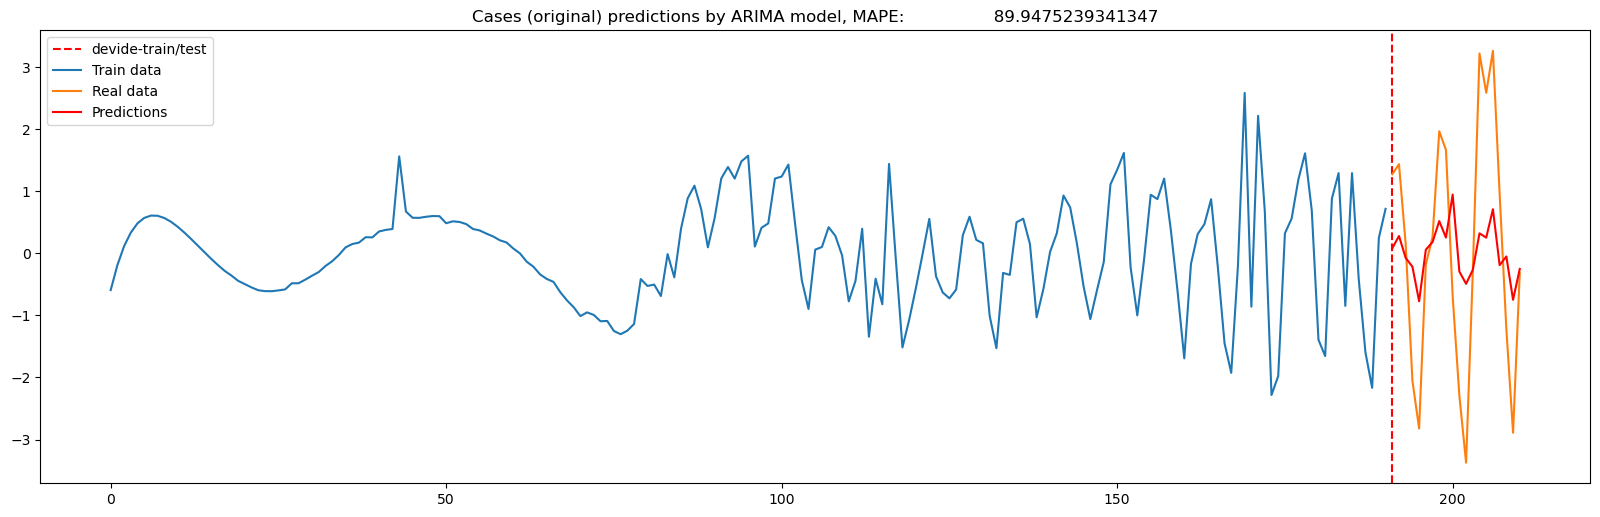

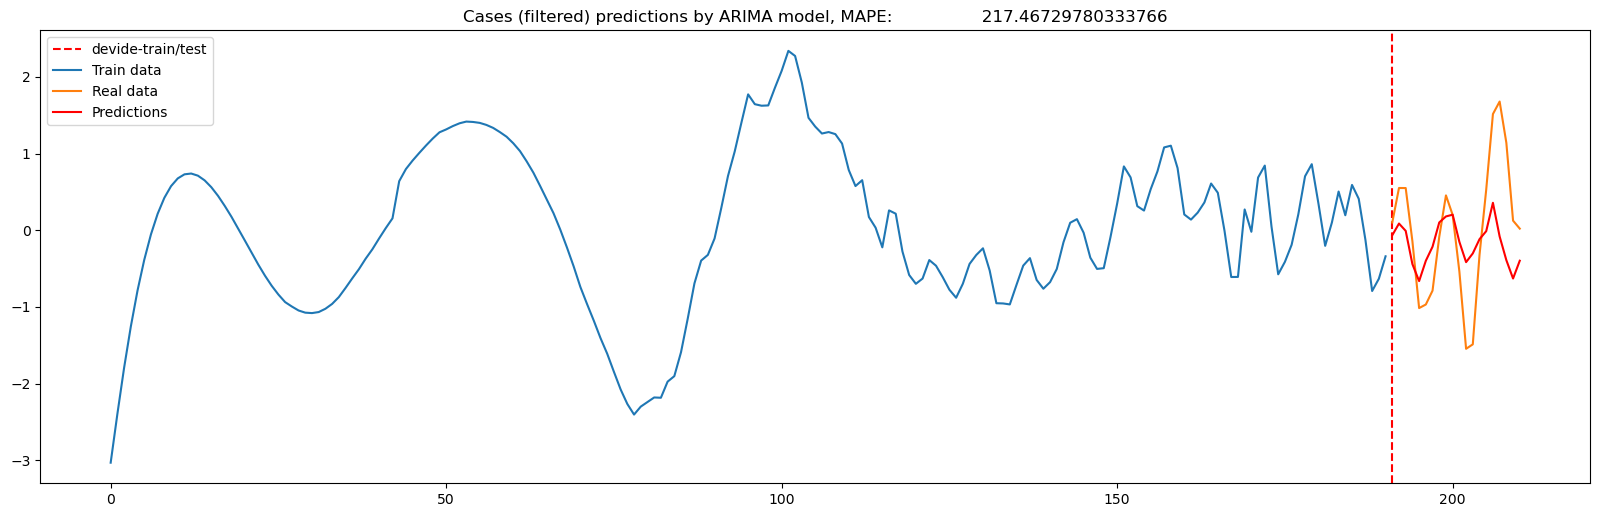

In [318]:
# ARIMA forecast
arima_original_metrics = arima_forecast(X_train,
                                X_test, 
                                y_train, 
                                y_test, 
                                'Cases (original)', 
                                (1,0,2), (2,0,0, 12), 
                                'ARIMA')
arima_filtered_metrics = arima_forecast(X_train, 
                                X_test, 
                                y_filtered_train, 
                                y_filtered_test, 
                                'Cases (filtered)', 
                                (4,0,4), (1,0,0,12), 
                                'ARIMA')
cases_metrics['arima_original_metrics'] = arima_original_metrics
cases_metrics['arima_filtered_metrics'] = arima_filtered_metrics

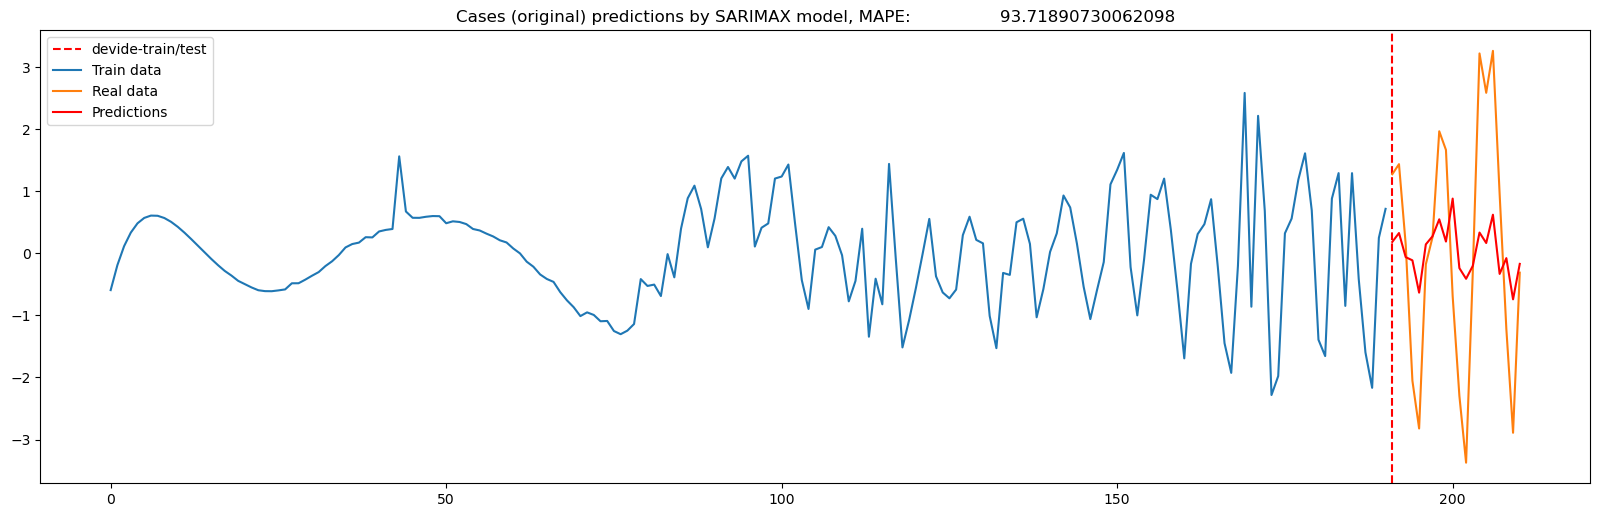

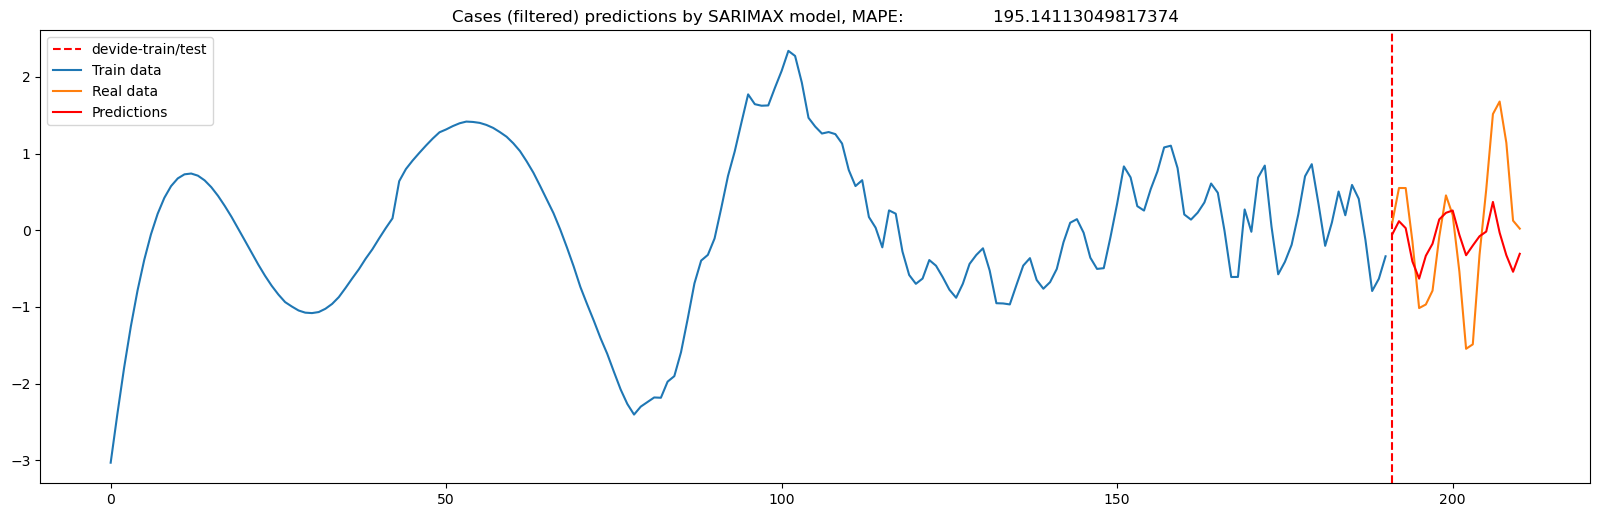

In [319]:
# SARIMAX forecast
sarimax_original_metrics = arima_forecast(X_train, 
                                          X_test, 
                                          y_train, 
                                          y_test, 
                                          'Cases (original)', 
                                          (1,0,2), (2,0,0, 12), 
                                          'SARIMAX')
sarimax_filtered_metrics = arima_forecast(X_train, 
                                          X_test, 
                                          y_filtered_train, 
                                          y_filtered_test, 
                                          'Cases (filtered)', 
                                          (4,0,4), (1,0,0,12), 
                                          'SARIMAX')

cases_metrics['sarimax_original_metrics'] = sarimax_original_metrics
cases_metrics['sarimax_filtered_metrics'] = sarimax_filtered_metrics

In [320]:
#################################### Make forecast for DEATHS target ############################################
X = df_with_lags.iloc[:, 3:]
y = df_with_lags.deaths
y_filtered = np.array(Kalman_filt_targs[1][1:])

X = np.array(X).squeeze()
y = np.array(y).squeeze()
y_filtered = np.array(y_filtered).squeeze()

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))
y_filtered = scaler.fit_transform(y_filtered.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)
X_train, X_test, y_filtered_train, y_filtered_test = train_test_split(X, y_filtered, test_size=20, shuffle=False)

# metrics logs
deaths_metrics = {}

In [261]:
# Search parameters for original data
model = pm.auto_arima(y_train,
                      seasonal=True, 
                      m=12, 
                      trace=True, 
                      suppress_warnings=True, 
                      error_action='ignore', 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=416.515, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=523.554, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=459.627, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=472.451, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=521.566, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=416.282, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=419.283, Time=0.13 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=415.113, Time=0.70 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=417.055, Time=0.98 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=447.790, Time=0.44 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=449.301, Time=0.60 sec
 ARIMA(3,0,2)(0,0,2)[12] intercept   : AIC=449.926, Time=0.82 sec
 ARIMA(2,0,3)(0,0,2)[12] intercept   : AIC=416.131, Time=0.77 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=454.891, Time=0.30 sec
 ARIMA(1,0,3)(0,0,2)[12] intercep

In [297]:
# Search parameters for filtered data
model = pm.auto_arima(y_filtered_train,
                      seasonal=False, 
                      m=12, 
                      trace=True, 
                      suppress_warnings=True, 
                      error_action='ignore', 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-24.789, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=553.209, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=35.298, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=339.904, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-26.529, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=175.382, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-8.794, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-24.651, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=96.234, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-20.102, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-23.205, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-24.777, Time=0.10 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 0.752 seconds


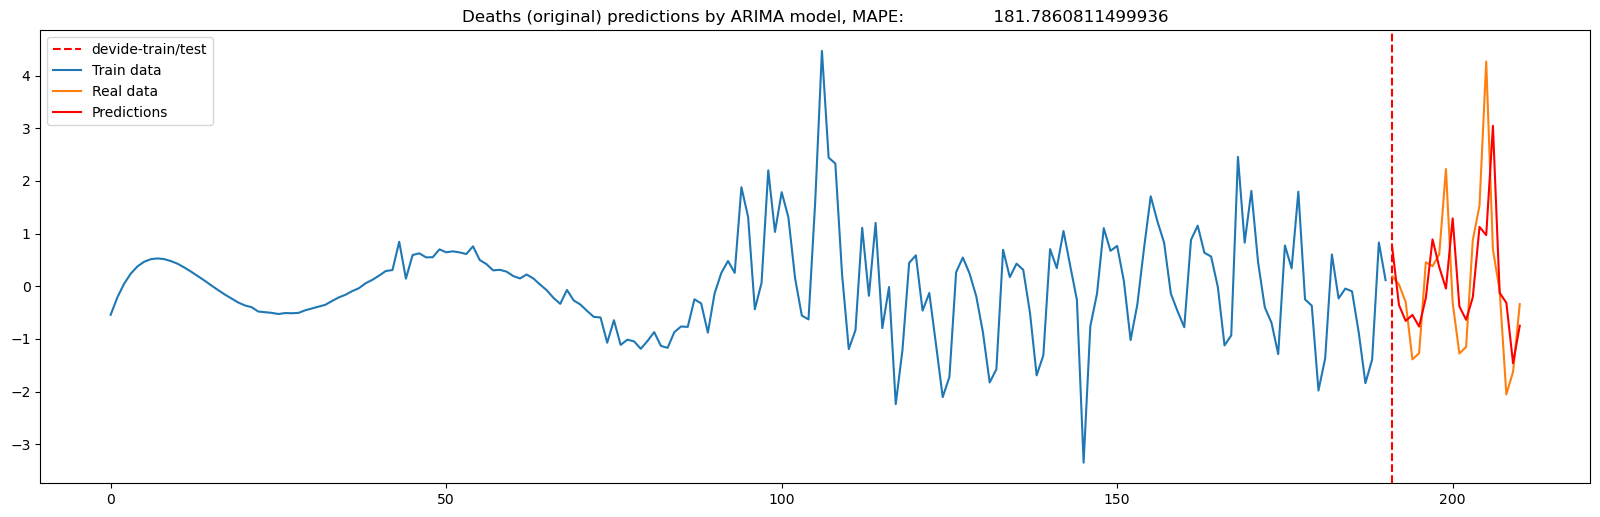

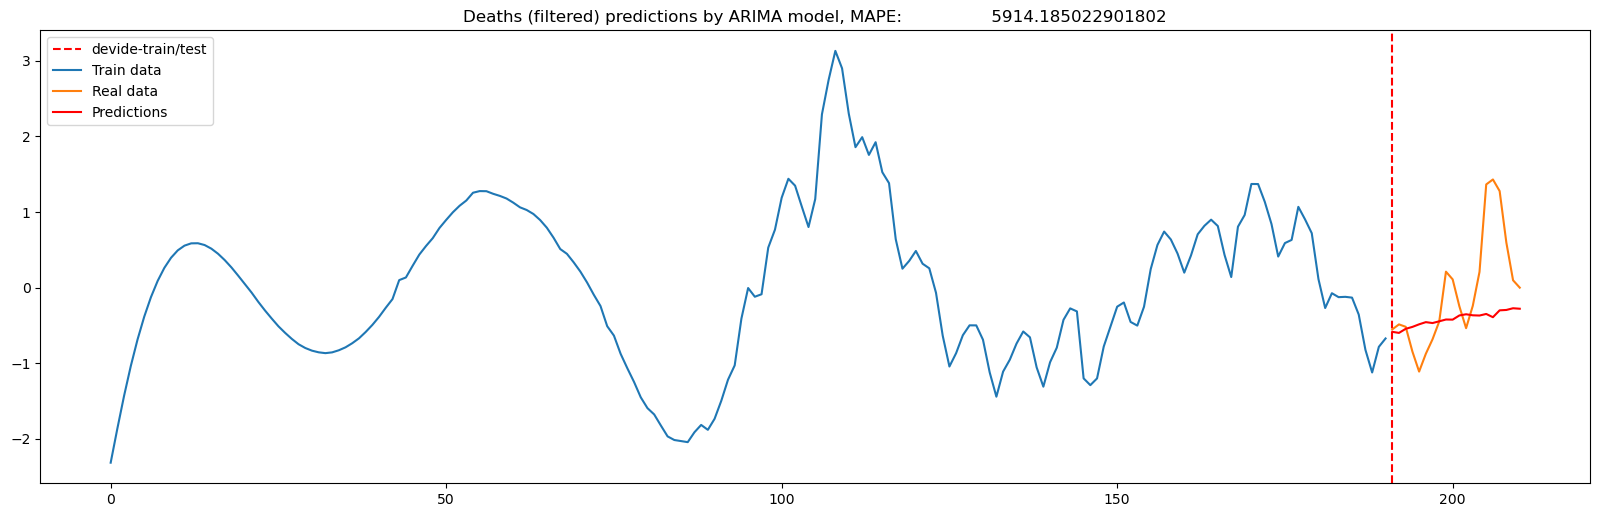

In [321]:
# ARIMA forecast
arima_original_metrics = arima_forecast(X_train, 
                                        X_test, 
                                        y_train, 
                                        y_test, 
                                        'Deaths (original)', 
                                        (3,0,5), (0,0,0, 12), 
                                        'ARIMA')
arima_filtered_metrics = arima_forecast(X_train, 
                                        X_test, 
                                        y_filtered_train, 
                                        y_filtered_test, 
                                        'Deaths (filtered)', 
                                        (1,0,2), (0,0,0,0), 
                                        'ARIMA')

deaths_metrics['arima_original_metrics'] = arima_original_metrics
deaths_metrics['arima_filtered_metrics'] = arima_filtered_metrics

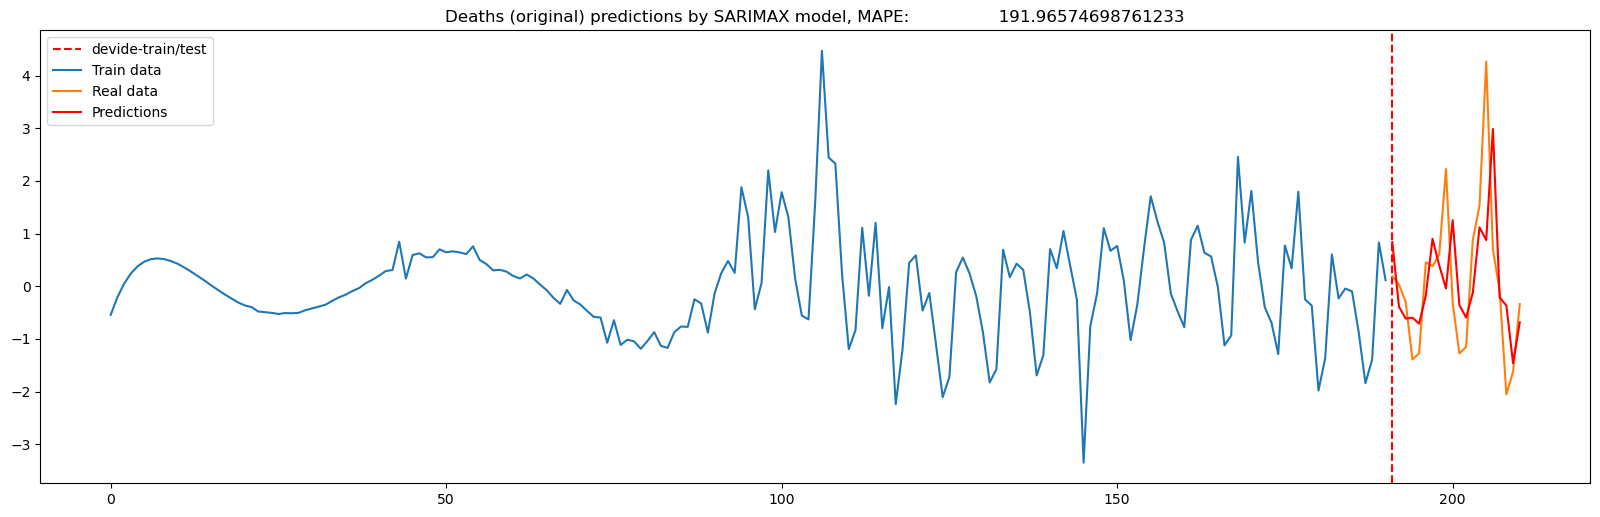

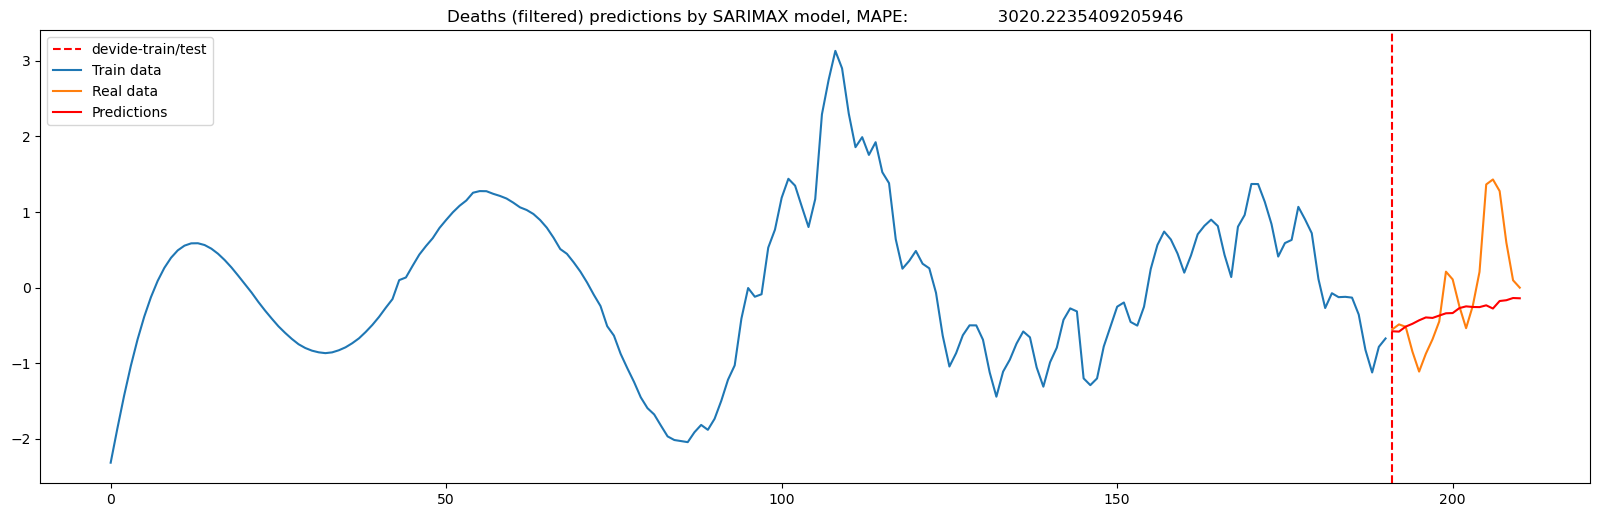

In [322]:
# SARIMAX forecast
sarimax_original_metrics = arima_forecast(X_train, 
                                          X_test, 
                                          y_train, 
                                          y_test, 
                                          'Deaths (original)', 
                                          (3,0,5), 
                                          (0,0,0, 12), 
                                          'SARIMAX')
sarimax_filtered_metrics = arima_forecast(X_train, 
                                          X_test, 
                                          y_filtered_train, 
                                          y_filtered_test, 
                                          'Deaths (filtered)', 
                                          (1,0,2), (0,0,0,0), 
                                          'SARIMAX')

deaths_metrics['sarimax_original_metrics'] = sarimax_original_metrics
deaths_metrics['sarimax_filtered_metrics'] = sarimax_filtered_metrics

In [346]:
################################################# Results ##########################################################
results = pd.concat([
    pd.DataFrame(cases_metrics, index=[
                            np.array(['cases', 'cases', 'cases']),
                            np.array(['RMSE', 'MAPE', 'R2 score'])
                                   ]),
    pd.DataFrame(deaths_metrics, index=[
                            np.array(['deaths', 'deaths', 'deaths']),
                            np.array(['RMSE', 'MAPE', 'R2 score'])
                                   ])
])

results['min'] = results.min(axis=1)
results['max'] = results.max(axis=1)

In [347]:
results

arima_original_metrics  arima_filtered_metrics  \
cases  RMSE                    1.690110                0.781593   
       MAPE                    0.899475                2.174673   
       R2 score                0.270766                0.195219   
deaths RMSE                    1.266041                0.760523   
       MAPE                    1.817861               59.141850   
       R2 score                0.219916               -0.099052   

                 sarimax_original_metrics  sarimax_filtered_metrics       min  \
cases  RMSE                      1.725178                  0.782893  0.781593   
       MAPE                      0.937189                  1.951411  0.899475   
       R2 score                  0.240190                  0.192541  0.192541   
deaths RMSE                      1.265715                  0.705965  0.705965   
       MAPE                      1.919657                 30.202235  1.817861   
       R2 score                  0.220317                  0.052978 -0.099052   

                       max  
cases  RMSE       1.725178  
       MAPE       2.174673  
       R2 score   0.270766  
deaths RMSE       1.266041  
       MAPE      59.141850  
       R2 score   0.220317

## Exercise №7

Build model in a form of linear dynamical system, using chosen predictors. To analyze residual error and to define appropriate order of model

In [391]:
def wrap_into_input(forecast_length, feature_time_series, target_time_series):
    """ Convert data for FEDOT framework """
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))
    
    input_data = InputData(idx=np.arange(0, len(target_time_series)),
                           features=feature_time_series, target=target_time_series,
                           task=task, data_type=DataTypesEnum.ts)
    
    return input_data

In [392]:
forecast_length = 20

ts_1 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(df_grouped['cases']),
                       target_time_series=np.array(df_grouped['cases']))

train_ts_1, test_ts_1 = train_test_data_setup(ts_1)

ts_2 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(df_grouped['deaths']),
                       target_time_series=np.array(df_grouped['deaths']))

train_ts_2, test_ts_2 = train_test_data_setup(ts_2)

dataset = MultiModalData({
    'data_source_ts/cases': ts_1,
    'data_source_ts/deaths': ts_2
})


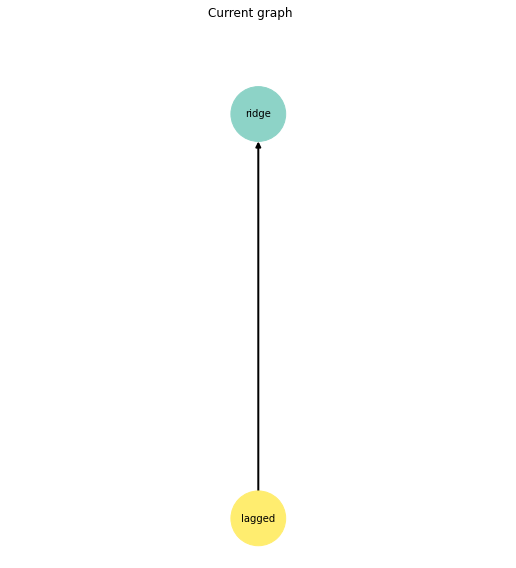

In [393]:
def simple_linear_pipeline():
    """ Pipeline lagged -> ridge """
    lagged_node = PrimaryNode('lagged')  
    ridge_node = SecondaryNode('ridge', nodes_from=[lagged_node])
    return Pipeline(ridge_node)

simple_pipeline = simple_linear_pipeline()
simple_pipeline.show()
simple_pipeline.fit(train_ts_1)
forecast_uni = simple_pipeline.predict(test_ts_1)

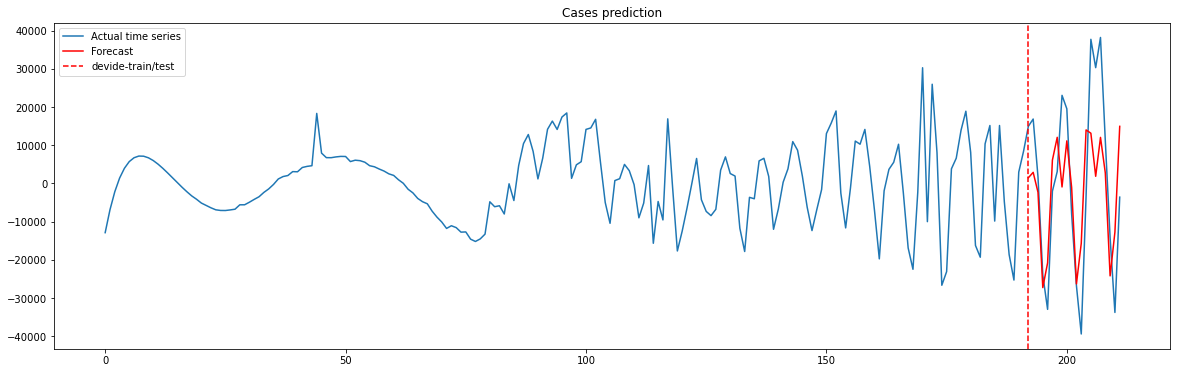

In [394]:
train_length = len(df_grouped['cases']) - forecast_length

plt.figure(figsize=(20,6))
plt.title('Cases prediction')

plt.plot(df_grouped['cases'], label='Actual time series')
plt.plot(np.arange(train_length, train_length + forecast_length), 
         np.ravel(forecast_uni.predict), label='Forecast', c='r')
plt.axvline(x=train_length, c='r', linestyle='--', label='devide-train/test')

plt.legend()
plt.show()

In [397]:
MAE = mean_absolute_error(test_ts_1.target, np.ravel(forecast_uni.predict))
MAPE = mean_absolute_percentage_error(test_ts_1.target, np.ravel(forecast_uni.predict))
MSE = mean_squared_error(test_ts_1.target, np.ravel(forecast_uni.predict))
print(f'MAE metric value: {MAE}\nMAPE metric value: {MAPE}\nMSE metric value: {MSE}')

MAE metric value: 14112.957614431361
MAPE metric value: 1.4476150450236713
MSE metric value: 265724871.76924127


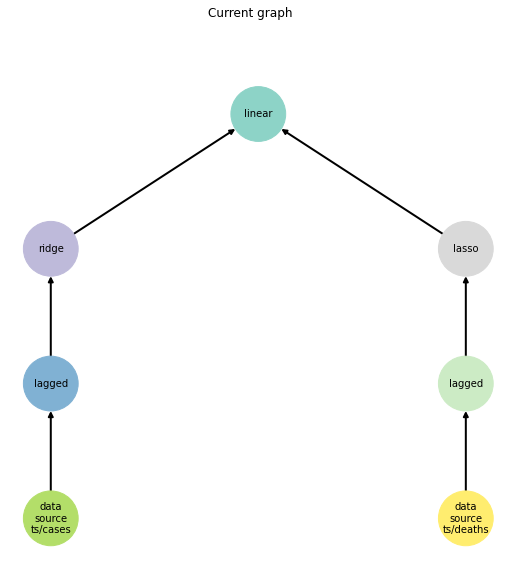

In [398]:
def create_multisource_pipeline():
    """ Generate pipeline with several data sources """
    node_source_1 = PrimaryNode('data_source_ts/cases')
    node_source_2 = PrimaryNode('data_source_ts/deaths')

    node_lagged_1 = SecondaryNode('lagged', nodes_from=[node_source_1])
    node_lagged_1.custom_params = {'window_size': 150}
    node_lagged_2 = SecondaryNode('lagged', nodes_from=[node_source_2])
      
    node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_lasso = SecondaryNode('lasso', nodes_from=[node_lagged_2])
    
    node_final = SecondaryNode('linear', nodes_from=[node_ridge, node_lasso])
    pipeline = Pipeline(node_final)
    return pipeline

pipeline = create_multisource_pipeline()
pipeline.show()

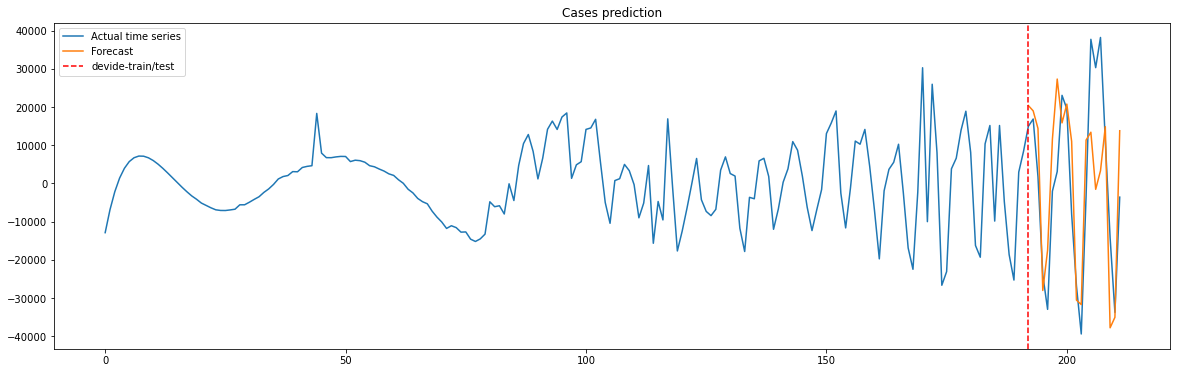

In [399]:
plt.figure(figsize=(20,6))
plt.title('Cases prediction')

pipeline.fit(train_ts_1)
forecast_multi = pipeline.predict(test_ts_1)

train_length = len(df_grouped['cases']) - forecast_length

plt.plot(df_grouped['cases'], label='Actual time series')
plt.plot(np.arange(train_length, train_length + forecast_length), 
         np.ravel(forecast_multi.predict), label='Forecast')
plt.axvline(x=train_length, c='r', linestyle='--', label='devide-train/test')

plt.legend()
plt.show()

In [400]:
MAE = mean_absolute_error(test_ts_1.target, np.ravel(forecast_multi.predict))
MAPE = mean_absolute_percentage_error(test_ts_1.target, np.ravel(forecast_multi.predict))
MSE = mean_squared_error(test_ts_1.target, np.ravel(forecast_multi.predict))
print(f'MAE metric value: {MAE}\nMAPE metric value: {MAPE}\nMSE metric value: {MSE}')

MAE metric value: 13414.557887756455
MAPE metric value: 1.985873058661581
MSE metric value: 281393427.73515576
